## Introduction

This notebook represents the network science part of this project where we build a social network graph out of the scraped tweets for the candidates running for parliamentary election in Denmark, Fall 2022.

## Import Dependancies

In [487]:
import pandas as pd
import re
import powerlaw
import ast
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from fa2 import ForceAtlas2
from community import community_louvain
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter
import networkx.algorithms.community as nx_comm
from matplotlib import colors
import matplotlib.patches as patches

## Import and Preprocess Data

In [326]:
tweets = pd.read_csv("../data/tweets.csv", index_col = 0, dtype={'userID':str,'tweetID':str})

In [327]:
tweets.head(5) # Inspect first five rows

tweetID     userID  \
0  1587190794502422528  606561223   
1  1587154827485782016  606561223   
2  1586826440980537088  606561223   
3  1586771334872408064  606561223   
4  1586349096910061568  606561223   

                                               tweet  
0  RT @MetteGjerskov: Så er der klar tale fra de ...  
1  RT @verdensskove: Sådan så det ud da @MaiVilla...  
2  Pape bruger klima-taletiden på at tale om arve...  
3  RT @DanmarksNatur: 85 procent af vælgerne støt...  
4  RT @IdaAuken: Regeringen har været den mest mi...

In [328]:
tweets.tail(5) # Inspect last five rows

tweetID      userID  \
53337  1401383460032352512  3300730179   
53338  1397834987446079488  3300730179   
53339   559437541309694016   479025309   
53340   558551516962107392   479025309   
53341   164129675726176256   479025309   

                                                   tweet  
53337  RT @NHOERUP: Vi skal give familierne omsorg, s...  
53338  @TheDorteOlsen Enig! Det er et problem at man ...  
53339  Found Sinai by Ilan Bluestone with #Shazam. ht...  
53340             @aboveandbeyond http://t.co/ntzRGiDzPn  
53341                                    Just LOVE #TATW

In [329]:
# Import CSV with user handle info
cand_info = pd.read_csv("../data/candidates_with_id.csv", index_col = 0, dtype={'id':str})
cand_info['Handle'] = cand_info['Handle'].str[1:]

In [330]:
cand_info.head(5) # Inspect first five rows

Name           Handle Party  \
0       Steen Frandsen    SteenFrandsen     A   
1  Lars B. Goldschmidt  LarsGoldschmidt     A   
2         Lea Wermelin      LeaWermelin     A   
3     Dave Christensen          Koach_C     B   
4     Niels E. Ebbesen         nebbesen     B   

                                                 Bio          id  
0                                                NaN  2524397176  
1                                                NaN  2423339089  
2  Miljøminister, bornholmer og folketingsmedlem ...   606561223  
3                     Retired College Football Coach  2374418474  
4                                                NaN   219248466

In [331]:
cand_info.tail(5) # Inspect last five rows

Name          Handle Party  \
1009             Sarah Geronimo      JustSarahG     Å   
1010                 Helle Wium           HWium     Å   
1011  Line Aaen ,- Alternativet       line_aaen     Å   
1012            Jesper Antonsen  JesperAntonsen  UDEN   
1013          Chresten H. Ibsen             one  UDEN   

                                                    Bio          id  
1009                                                NaN  1170817123  
1010  Alternativet's Storkredsbestyrelse Østjylland,...    39296795  
1011  Folketingskandidat, Underviser på VUC Djurslan...  3300730179  
1012                                                NaN   479025309  
1013                                               none   479025309

In [332]:
# Grab subset 
id_handle = cand_info[["Handle","id", "Party"]]
id_handle.head(5) # Inspect first five rows

Handle          id Party
0    SteenFrandsen  2524397176     A
1  LarsGoldschmidt  2423339089     A
2      LeaWermelin   606561223     A
3          Koach_C  2374418474     B
4         nebbesen   219248466     B

In [333]:
id_handle.tail(5) # Inspect last five rows

Handle          id Party
1009      JustSarahG  1170817123     Å
1010           HWium    39296795     Å
1011       line_aaen  3300730179     Å
1012  JesperAntonsen   479025309  UDEN
1013             one   479025309  UDEN

In [334]:
# Check Dtypes
id_handle.dtypes

Handle    object
id        object
Party     object
dtype: object

In [335]:
# Make dictionary with user IDs as keys and Twitter user handles as value
id_to_name = dict(zip(list(id_handle['id']), list(id_handle['Handle'])))

# Make dictionary with user IDs as keys and political party as value
id_to_party = dict(zip(list(id_handle['id']), list(id_handle['Party'])))

In [336]:
party = ["A", "B", "C", "D", "F", "I", "K", "M", "O", "Q", "UDEN", "V", "Å", "Æ", "Ø"]
block = ["left wing", "center", "right wing", "right wing", "left wing", "right wing", "center", "center", "right wing", "left wing", "none", "right wing", "left wing", "right wing", "left wing"]

In [337]:
# Make dictionary with parties as keys and political spectrum as value
party_to_block = dict(zip(party, block))

In [338]:
# Make new column with user handles
tweets['user_handle'] = tweets['userID'].map(id_to_name)
tweets['party'] = tweets['userID'].map(id_to_party)
tweets['pol_spectrum'] = tweets['party'].map(party_to_block)
tweets.head(5) # Inspect first five rows

tweetID     userID  \
0  1587190794502422528  606561223   
1  1587154827485782016  606561223   
2  1586826440980537088  606561223   
3  1586771334872408064  606561223   
4  1586349096910061568  606561223   

                                               tweet  user_handle party  \
0  RT @MetteGjerskov: Så er der klar tale fra de ...  LeaWermelin     A   
1  RT @verdensskove: Sådan så det ud da @MaiVilla...  LeaWermelin     A   
2  Pape bruger klima-taletiden på at tale om arve...  LeaWermelin     A   
3  RT @DanmarksNatur: 85 procent af vælgerne støt...  LeaWermelin     A   
4  RT @IdaAuken: Regeringen har været den mest mi...  LeaWermelin     A   

  pol_spectrum  
0    left wing  
1    left wing  
2    left wing  
3    left wing  
4    left wing

In [339]:
tweets.tail(5) # Inspect last five rows

tweetID      userID  \
53337  1401383460032352512  3300730179   
53338  1397834987446079488  3300730179   
53339   559437541309694016   479025309   
53340   558551516962107392   479025309   
53341   164129675726176256   479025309   

                                                   tweet user_handle party  \
53337  RT @NHOERUP: Vi skal give familierne omsorg, s...   line_aaen     Å   
53338  @TheDorteOlsen Enig! Det er et problem at man ...   line_aaen     Å   
53339  Found Sinai by Ilan Bluestone with #Shazam. ht...         one  UDEN   
53340             @aboveandbeyond http://t.co/ntzRGiDzPn         one  UDEN   
53341                                    Just LOVE #TATW         one  UDEN   

      pol_spectrum  
53337    left wing  
53338    left wing  
53339         none  
53340         none  
53341         none

In [340]:
def get_mentions(tweet):
    """Find mentions of users in tweets.

        Args:
            tweet (str): The tweet to find mentions from.

        Returns:
            list: List of matches in string
    """
    # Use Regex to find letters and numbers after @, i.e., mentions on Twitter
    pattern = r'@([A-Za-z0-9_]+)'
    
    # Return all matches in list
    match = re.findall(pattern, tweet)

    return match

In [341]:
tweets = tweets.dropna(subset = ["tweet"]) # Drop rows with empty tweets

In [342]:
tweets.shape # Inspect shape of DF

(53341, 6)

In [343]:
# Apply function to find mentions on all rows of data.
# This is the most efficient way of doing so; considerably faster than looping over all rows.
tweets['mention'] = tweets['tweet'].apply(get_mentions)

In [344]:
tweets.head(5) # Inspect first five rows

tweetID     userID  \
0  1587190794502422528  606561223   
1  1587154827485782016  606561223   
2  1586826440980537088  606561223   
3  1586771334872408064  606561223   
4  1586349096910061568  606561223   

                                               tweet  user_handle party  \
0  RT @MetteGjerskov: Så er der klar tale fra de ...  LeaWermelin     A   
1  RT @verdensskove: Sådan så det ud da @MaiVilla...  LeaWermelin     A   
2  Pape bruger klima-taletiden på at tale om arve...  LeaWermelin     A   
3  RT @DanmarksNatur: 85 procent af vælgerne støt...  LeaWermelin     A   
4  RT @IdaAuken: Regeringen har været den mest mi...  LeaWermelin     A   

  pol_spectrum                                            mention  
0    left wing                                    [MetteGjerskov]  
1    left wing  [verdensskove, MaiVilladsen, sofiecn, PiaOlsen...  
2    left wing                                                 []  
3    left wing                                    [DanmarksNatur]  
4    left wing           [IdaAuken, BirdLifeDanmark, LeaWermelin]

In [345]:
# Do not consider rows where there are no mentions, i.e., we do not want singleton nodes in the network
tweets_w_mentions = tweets[tweets['mention'].map(lambda m: len(m)) > 0]
tweets_w_mentions.head(5) # Inspect first five rows

tweetID     userID  \
0  1587190794502422528  606561223   
1  1587154827485782016  606561223   
3  1586771334872408064  606561223   
4  1586349096910061568  606561223   
5  1586262864192737280  606561223   

                                               tweet  user_handle party  \
0  RT @MetteGjerskov: Så er der klar tale fra de ...  LeaWermelin     A   
1  RT @verdensskove: Sådan så det ud da @MaiVilla...  LeaWermelin     A   
3  RT @DanmarksNatur: 85 procent af vælgerne støt...  LeaWermelin     A   
4  RT @IdaAuken: Regeringen har været den mest mi...  LeaWermelin     A   
5  RT @DANVA1926: Sikring af det rene drikkevand ...  LeaWermelin     A   

  pol_spectrum                                            mention  
0    left wing                                    [MetteGjerskov]  
1    left wing  [verdensskove, MaiVilladsen, sofiecn, PiaOlsen...  
3    left wing                                    [DanmarksNatur]  
4    left wing           [IdaAuken, BirdLifeDanmark, LeaWermelin]  
5    left wing                                        [DANVA1926]

In [346]:
tweets_w_mentions.shape

(40780, 7)

In [347]:
# Construct network by connecting nodes (users - politicians) that mention eachother (links) in their tweets
edge_dict = dict(zip(tweets_w_mentions['user_handle'], tweets_w_mentions['mention']))

In [348]:
G = nx.DiGraph(edge_dict) # Make directed graph

In [349]:
print("Number of edges:")
len(G.edges)

Number of edges:


490

In [350]:
print("Number of nodes:")
len(G.nodes)

Number of nodes:


646

**Check in/out-degree:**

In [351]:
# In-degrees
tuples_in_deg = G.in_degree(G.nodes())
in_deg = [x[1] for x in tuples_in_deg] 

In [352]:
# Out-degrees
tuples_out_deg = G.out_degree(G.nodes())
out_deg = [x[1] for x in tuples_out_deg] 

In [353]:
print('In degree\tmax: {}\tmin: {}\tmedian: {}'.format(max(in_deg),min(in_deg), np.median(in_deg)))
print('Out degree\tmax: {}\tmin: {}\tmedian: {}'.format(max(out_deg),min(out_deg),np.median(out_deg)))
print('Nodes with in-degree larger than 100: {}'.format(len([i for i in in_deg if i >5])))

In degree	max: 8	min: 0	median: 1.0
Out degree	max: 12	min: 0	median: 0.0
Nodes with in-degree larger than 100: 3


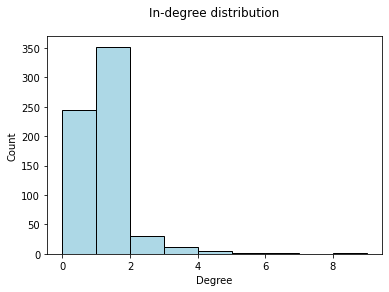

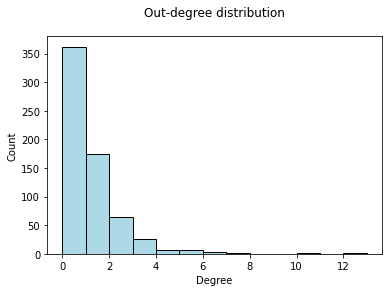

In [354]:
## Plot degree distributions
plt.title("In-degree distribution",pad = 20.0)
plt.hist(in_deg, bins = np.arange(np.min(in_deg), np.max(in_deg)+2), color = 'lightblue', edgecolor = 'black')
plt.ylabel("Count")
plt.xlabel("Degree")
plt.show()

plt.title("Out-degree distribution",pad = 20.0)
plt.hist(out_deg, bins = np.arange(np.min(out_deg), np.max(out_deg)+2), color = 'lightblue', edgecolor = 'black')
plt.ylabel("Count")
plt.xlabel("Degree")
plt.show()

**Estimating the Degree Exponents**

In [488]:
in_degrees = [d for n,d in G.in_degree()]
out_degrees = [d for n,d in G.out_degree()]
all_degrees = [d for n,d in G.degree()]


in_alpha = powerlaw.Fit(in_degrees).alpha 
out_alpha = powerlaw.Fit(out_degrees).alpha 
all_alpha = powerlaw.Fit(all_degrees).alpha 

print('The degree exponent for in-, out- and total- degree distribution is {}, {} and {}.'.format(in_alpha, out_alpha, all_alpha))

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
The degree exponent for in-, out- and total- degree distribution is 9.5381097740159, 5.934757979067971 and 4.7074666203055155.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


In [355]:
## Most connected users
in_deg_dict = dict(G.in_degree(G.nodes))
print("Top most in-degree connected users: ,", sorted(in_deg_dict, key=in_deg_dict.get, reverse=True)[:20])

out_deg_dict = dict(G.out_degree(G.nodes))
print("Top most out-degree connected users: ,", sorted(out_deg_dict, key=out_deg_dict.get, reverse=True)[:10])

Top most in-degree connected users: , ['alternativet_', 'KonservativeDK', 'venstredk', 'berlingske', 'metteabildgaard', 'SorenPape', 'Spolitik', 'radikale', 'MagnusBarsoe', 'RosaLundEl', 'YouTube', 'Enhedslisten', 'DanskIndustri', 'aahlers', 'olebirkolesen', 'uffeelbaek', 'KBRH87', 'tv2newsdk', 'dkpolparrot', 'LiberalAlliance']
Top most out-degree connected users: , ['MarleneAmbo', 'Scheelsbeck', 'AneHalsboe', 'hannebjornk', 'PLindhoutTravel', 'martinlidegaard', 'ThDanielsen', 'SamiraNawa', 'jobywatermusic', 'LarsPrahm']


**In-/out-degree Across Party Affiliation**

In [356]:
## Create dict containing party affiliation as node attributes

# Initialize empty dict
empty_dict = dict.fromkeys(range(0, len(tweets_w_mentions)))

# Loop through all nodes and add its corresponding party as node attribute
for i in tqdm(range(len(G.nodes))):
    try:
        j = np.where(tweets_w_mentions["user_handle"] == list(G.nodes)[i])[0][0]
        empty_dict[i] = {'party':list(tweets_w_mentions['party'])[j], 'pol_spectrum':list(tweets_w_mentions['pol_spectrum'])[j]}
    
    # For the users not included in the dataset, but only mentioned by other users, set party affiliation as "unk"    
    except IndexError: 
        empty_dict[i] = {'party':"unk", 'pol_spectrum': "unk"}

  0%|          | 0/646 [00:00<?, ?it/s]

In [357]:
# Change the key values to the user handles
empty_dict = dict(zip(list(G.nodes),list(empty_dict.values()))) 

In [358]:
# Set node attributes from the party affiliation dict we just defined
nx.set_node_attributes(G, empty_dict)

In [513]:
in_deg_A = []
in_deg_B = []
in_deg_C = []
in_deg_D = []
in_deg_F = []
in_deg_I = []
in_deg_K = []
in_deg_M = []
in_deg_O = []
in_deg_Q = []
in_deg_V = []
in_deg_Æ = []
in_deg_Ø = []
in_deg_Å = []
in_deg_UDEN = []

out_deg_A = []
out_deg_B = []
out_deg_C = []
out_deg_D = []
out_deg_F = []
out_deg_I = []
out_deg_K = []
out_deg_M = []
out_deg_O = []
out_deg_Q = []
out_deg_V = []
out_deg_Æ = []
out_deg_Ø = []
out_deg_Å = []
out_deg_UDEN = []

# Define colors for all parties
for node in tqdm(list(G.nodes())):

    if nx.get_node_attributes(G,'party')[node] == 'A': # Soc. Dem.
        in_deg_A.append(G.in_degree(node))
        out_deg_A.append(G.out_degree(node))

    elif nx.get_node_attributes(G,'party')[node] == 'B': # Radikale venstre
        in_deg_B.append(G.in_degree(node))
        out_deg_B.append(G.out_degree(node))

    elif nx.get_node_attributes(G,'party')[node] == 'C': # Konservative
        in_deg_C.append(G.in_degree(node))
        out_deg_C.append(G.out_degree(node))

    elif nx.get_node_attributes(G,'party')[node] == 'D': # Nye Borgerlige
        in_deg_D.append(G.in_degree(node))
        out_deg_D.append(G.out_degree(node))

    elif nx.get_node_attributes(G,'party')[node] == 'F': # SF
        in_deg_F.append(G.in_degree(node))
        out_deg_F.append(G.out_degree(node))

    elif nx.get_node_attributes(G,'party')[node] == 'I': # LA
        in_deg_I.append(G.in_degree(node))
        out_deg_I.append(G.out_degree(node))

    elif nx.get_node_attributes(G,'party')[node] == 'K': # KD
        in_deg_K.append(G.in_degree(node))
        out_deg_K.append(G.out_degree(node))

    elif nx.get_node_attributes(G,'party')[node] == 'M': # Moderaterne
        in_deg_M.append(G.in_degree(node))
        out_deg_M.append(G.out_degree(node))

    elif nx.get_node_attributes(G,'party')[node] == 'O': # DF
        in_deg_O.append(G.in_degree(node))
        out_deg_O.append(G.out_degree(node))

    elif nx.get_node_attributes(G,'party')[node] == 'Q': # Frie grønne
        in_deg_Q.append(G.in_degree(node))
        out_deg_Q.append(G.out_degree(node))

    elif nx.get_node_attributes(G,'party')[node] == 'V': # Venstre
        in_deg_V.append(G.in_degree(node))
        out_deg_V.append(G.out_degree(node))

    elif nx.get_node_attributes(G,'party')[node] == 'Æ': # DK demokraterne
        in_deg_Æ.append(G.in_degree(node))
        out_deg_Æ.append(G.out_degree(node))

    elif nx.get_node_attributes(G,'party')[node] == 'Ø': # Enhedslisten
        in_deg_Ø.append(G.in_degree(node))
        out_deg_Ø.append(G.out_degree(node))

    elif nx.get_node_attributes(G,'party')[node] == 'Å': # Alternativet
        in_deg_Å.append(G.in_degree(node))
        out_deg_Å.append(G.out_degree(node))

    elif nx.get_node_attributes(G,'party')[node] == 'UDEN':
        in_deg_UDEN.append(G.in_degree(node))
        out_deg_UDEN.append(G.out_degree(node))

  0%|          | 0/646 [00:00<?, ?it/s]

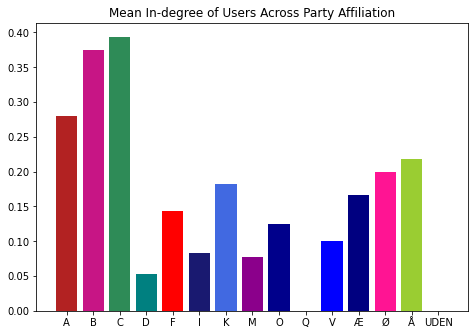

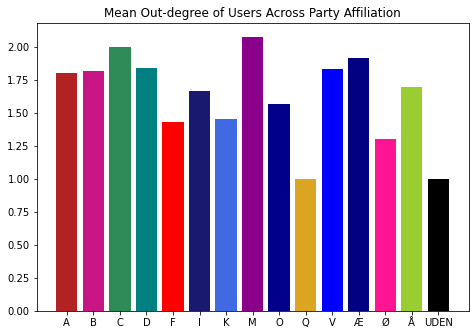

In [515]:
unique_parties_lst = ['A', 'B', 'C', 'D', 'F', 'I', 'K', 'M', 'O', 'Q', 'V', 'Æ', 'Ø', 'Å', 'UDEN']


color_dict_ = {"firebrick": "A", "mediumvioletred": "B", "seagreen": "C", "teal": "D", "red": "F", "midnightblue": "I", 
              "royalblue": "K", "darkmagenta": "M", "darkblue": "O", "goldenrod": "Q", "blue": "V", "navy": "Æ",
              "deeppink": "Ø", "yellowgreen": "Å", "black": 'UDEN'}

def party_aff_plot(unique_list, count_list, title, color_dict):
    """Make barplot of party affiliation in community.

        Args:
            unique_list (list): Output from unique_and_count(), list of unique parties present in community.
            count_list (list): Output from unique_and_count(), count of party occurence.
            title (str): Plot title.
            color_dict (dict): Dictionary of parties and their respective colors.

    """
    rev_subs = {v:k for k, v in color_dict.items()}

    fig = plt.figure()

    ax = fig.add_axes([0,0,1,1])
    parties = unique_list
    counts = count_list
    
    ax.bar(parties,counts, color = [rev_subs.get(item,item)  for item in unique_list])
    plt.title(title)
    plt.show()



party_aff_plot(unique_parties_lst, [np.mean(in_deg_A), np.mean(in_deg_B), np.mean(in_deg_C), np.mean(in_deg_D), np.mean(in_deg_F), np.mean(in_deg_I), np.mean(in_deg_K), np.mean(in_deg_M), np.mean(in_deg_O), np.mean(in_deg_Q), np.mean(in_deg_V), np.mean(in_deg_Æ), np.mean(in_deg_Ø), np.mean(in_deg_Å), np.mean(in_deg_UDEN)], "Mean In-degree of Users Across Party Affiliation",color_dict_)
party_aff_plot(unique_parties_lst, [np.mean(out_deg_A), np.mean(out_deg_B), np.mean(out_deg_C), np.mean(out_deg_D), np.mean(out_deg_F), np.mean(out_deg_I), np.mean(out_deg_K), np.mean(out_deg_M), np.mean(out_deg_O), np.mean(out_deg_Q), np.mean(out_deg_V), np.mean(out_deg_Æ), np.mean(out_deg_Ø), np.mean(out_deg_Å), np.mean(out_deg_UDEN)], "Mean Out-degree of Users Across Party Affiliation",color_dict_)

**Visualization of Network**

In [380]:
# Convert to undirected graph for visualization purposes (so we do not end up with a lot of arrows)
G_visualize = G.to_undirected()

In [381]:
def color_maps(G_visualize, pol_spec):
    """Create color maps for nodes and edges.

        Args:
            G_visualize (NetworkX Graph object): Social network graph to create color maps for.
            pol_spec (bool): Whether not to use color maps for political affiliation.

        Returns:
            list: Color map for nodes.
            list: Color map for edges.
    """
    # Get in-degrees in dict
    degree_dict = dict(G_visualize.degree)
    if not pol_spec:
        
        ## Node color map ##
        color_map_nodes = []

        # Define colors for all parties
        for node in tqdm(list(G_visualize.nodes())):

            if nx.get_node_attributes(G_visualize,'party')[node] == 'A': # Soc. Dem.
                color_map_nodes.append("firebrick")

            elif nx.get_node_attributes(G_visualize,'party')[node] == 'B': # Radikale venstre
                color_map_nodes.append("mediumvioletred")

            elif nx.get_node_attributes(G_visualize,'party')[node] == 'C': # Konservative
                color_map_nodes.append("seagreen")

            elif nx.get_node_attributes(G_visualize,'party')[node] == 'D': # Nye Borgerlige
                color_map_nodes.append("teal")

            elif nx.get_node_attributes(G_visualize,'party')[node] == 'F': # SF
                color_map_nodes.append("red")

            elif nx.get_node_attributes(G_visualize,'party')[node] == 'I': # LA
                color_map_nodes.append("midnightblue")

            elif nx.get_node_attributes(G_visualize,'party')[node] == 'K': # KD
                color_map_nodes.append("royalblue")

            elif nx.get_node_attributes(G_visualize,'party')[node] == 'M': # Moderaterne
                color_map_nodes.append("darkmagenta")

            elif nx.get_node_attributes(G_visualize,'party')[node] == 'O': # DF
                color_map_nodes.append("darkblue")

            elif nx.get_node_attributes(G_visualize,'party')[node] == 'Q': # Frie grønne
                color_map_nodes.append("goldenrod")

            elif nx.get_node_attributes(G_visualize,'party')[node] == 'V': # Venstre
                color_map_nodes.append("blue")

            elif nx.get_node_attributes(G_visualize,'party')[node] == 'Æ': # DK demokraterne
                color_map_nodes.append("navy")

            elif nx.get_node_attributes(G_visualize,'party')[node] == 'Ø': # Enhedslisten
                color_map_nodes.append("deeppink")

            elif nx.get_node_attributes(G_visualize,'party')[node] == 'Å': # Alternativet
                color_map_nodes.append("yellowgreen")

            elif nx.get_node_attributes(G_visualize,'party')[node] == 'UDEN':
                color_map_nodes.append("black")

            elif nx.get_node_attributes(G_visualize,'party')[node] == 'unk':
                color_map_nodes.append("dimgray")

            else:
                color_map_nodes.append("lightslategray")

        ## Edge color map ##
        color_map_edge = []

        # Define colors for all parties
        for i in tqdm(list(G_visualize.edges())):

            if nx.get_node_attributes(G_visualize, 'party')[i[0]] != nx.get_node_attributes(G_visualize, 'party')[i[1]]:
                color_map_edge.append("slategray") # Links across party affiliation

            elif nx.get_node_attributes(G_visualize, 'party')[i[0]] == 'A': # A-A
                color_map_edge.append("tomato")

            elif nx.get_node_attributes(G_visualize, 'party')[i[0]] == 'B': # B-B
                color_map_edge.append("hotpink")

            elif nx.get_node_attributes(G_visualize, 'party')[i[0]] == 'C': # C-C
                color_map_edge.append("darkseagreen")

            elif nx.get_node_attributes(G_visualize, 'party')[i[0]] == 'D': # D-D
                color_map_edge.append("cadetblue")

            elif nx.get_node_attributes(G_visualize, 'party')[i[0]] == 'F': # F-F
                color_map_edge.append("orangered")

            elif nx.get_node_attributes(G_visualize, 'party')[i[0]] == 'I': # I-I
                color_map_edge.append("lightskyblue")

            elif nx.get_node_attributes(G_visualize, 'party')[i[0]] == 'K': # K-K
                color_map_edge.append("cornflowerblue")

            elif nx.get_node_attributes(G_visualize, 'party')[i[0]] == 'M': # M-M
                color_map_edge.append("darkviolet")

            elif nx.get_node_attributes(G_visualize, 'party')[i[0]] == 'O': # O-O
                color_map_edge.append("dodgerblue")

            elif nx.get_node_attributes(G_visualize, 'party')[i[0]] == 'Q': # Q-Q
                color_map_edge.append("yellow")

            elif nx.get_node_attributes(G_visualize, 'party')[i[0]] == 'V': # V-V
                color_map_edge.append("steelblue")

            elif nx.get_node_attributes(G_visualize, 'party')[i[0]] == 'Æ': # Æ-Æ
                color_map_edge.append("skyblue")

            elif nx.get_node_attributes(G_visualize, 'party')[i[0]] == 'Ø': # Ø-Ø
                color_map_edge.append("lightpink")

            elif nx.get_node_attributes(G_visualize, 'party')[i[0]] == 'Å': # Å-Å
                color_map_edge.append("lime")

            elif nx.get_node_attributes(G_visualize, 'party')[i[0]] == 'UDEN': # UDEN-UDEN
                color_map_edge.append("darkslategray")

            elif nx.get_node_attributes(G_visualize, 'party')[i[0]] == 'unk': # unk-unk
                color_map_edge.append("dimgrey")

            else:
                color_map_edge.append("slategrey")
    else:
        ## Node color map ##
        color_map_nodes = []

        # Define colors for all parties
        for node in tqdm(list(G_visualize.nodes())):

            if nx.get_node_attributes(G_visualize,'pol_spectrum')[node] == 'left wing': 
                color_map_nodes.append("firebrick")

            elif nx.get_node_attributes(G_visualize,'pol_spectrum')[node] == 'right wing': 
                color_map_nodes.append("blue")

            elif nx.get_node_attributes(G_visualize,'pol_spectrum')[node] == 'center': 
                color_map_nodes.append("darkmagenta")

            elif nx.get_node_attributes(G_visualize,'pol_spectrum')[node] == 'none': 
                color_map_nodes.append("darkslategray")

            elif nx.get_node_attributes(G_visualize,'pol_spectrum')[node] == 'unk': 
                color_map_nodes.append("dimgrey")


        ## Edge color map ##
        color_map_edge = []

        # Define colors for all parties
        for i in tqdm(list(G_visualize.edges())):

            if nx.get_node_attributes(G_visualize, 'pol_spectrum')[i[0]] != nx.get_node_attributes(G_visualize, 'pol_spectrum')[i[1]]:
                color_map_edge.append("slategray") # Links across party affiliation

            elif nx.get_node_attributes(G_visualize, 'pol_spectrum')[i[0]] == 'left wing': # left wing-left wing
                color_map_edge.append("tomato")

            elif nx.get_node_attributes(G_visualize, 'pol_spectrum')[i[0]] == 'right wing': # right wing-right wing
                color_map_edge.append("steelblue")

            elif nx.get_node_attributes(G_visualize, 'pol_spectrum')[i[0]] == 'center': # center-center
                color_map_edge.append("darkviolet")

            elif nx.get_node_attributes(G_visualize, 'pol_spectrum')[i[0]] == 'none': # center-center
                color_map_edge.append("slategray")

            elif nx.get_node_attributes(G_visualize, 'pol_spectrum')[i[0]] == 'unk': # center-center
                color_map_edge.append("grey")
                
    return color_map_nodes, color_map_edge, degree_dict

#Create a color map for the parties
color_map_legend = {}
color_map_legend['Frie Grønne'] = 'goldenrod'
color_map_legend['Enhedslisten'] = 'deeppink'
color_map_legend['SF'] = 'red'
color_map_legend['Alternativet'] = 'yellowgreen'
color_map_legend['Soc. Dem.'] = 'firebrick'
color_map_legend['Radikale Venstre'] = 'mediumvioletred'
color_map_legend['Moderaterne'] = 'darkmagenta'
color_map_legend['KD'] = 'royalblue'
color_map_legend['V'] = 'blue'
color_map_legend['DF'] = 'darkblue'
color_map_legend['LA'] = 'midnightblue'
color_map_legend['De Konservative'] = 'seagreen'
color_map_legend['DKdemokraterne'] = 'navy'
color_map_legend['Nye Borgerlige'] = 'teal'
color_map_legend['unk'] = 'dimgrey'
color_map_legend['Non-affiliated'] = 'black'

#Create a color map for the parties
color_map_legend_pol_spectrum = {}
color_map_legend_pol_spectrum['Left Wing'] = 'firebrick'
color_map_legend_pol_spectrum['Right Wing'] = 'blue'
color_map_legend_pol_spectrum['Center'] = 'darkmagenta'
color_map_legend_pol_spectrum['Non-affiliated'] = 'darkslategray'
color_map_legend_pol_spectrum['unk'] = 'dimgrey'

unique_parties = ['Frie Grønne', 'Enhedslisten', 'SF', 'Alternativet', 'Soc. Dem.', 'Radikale Venstre', 'Moderaterne', 'KD', 'V', 'DF', 'LA', 'De Konservative', 'DKdemokraterne', 'Nye Borgerlige', 'unk', 'Non-affiliated']
unique_pol_spec = ['Left Wing', 'Right Wing', 'Center', 'Non-affiliated', 'unk']

rgb = colors.to_rgba_array([color_map_legend[party] for party in unique_parties])
handles_dict = {patches.Patch(color = rgb, label = party) for party, rgb in color_map_legend.items()}

rgb_pol_spec = colors.to_rgba_array([color_map_legend_pol_spectrum[party] for party in unique_pol_spec])
handles_dict_pol_spec = {patches.Patch(color = rgb, label = party) for party, rgb in color_map_legend_pol_spectrum.items()}

In [382]:
color_map_nodes, color_map_edge, degree_dict = color_maps(G_visualize, pol_spec = False)

  0%|          | 0/646 [00:00<?, ?it/s]

  0%|          | 0/490 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:15<00:00, 125.14it/s]


BarnesHut Approximation  took  2.46  seconds
Repulsion forces  took  12.84  seconds
Gravitational forces  took  0.05  seconds
Attraction forces  took  0.02  seconds
AdjustSpeedAndApplyForces step  took  0.45  seconds


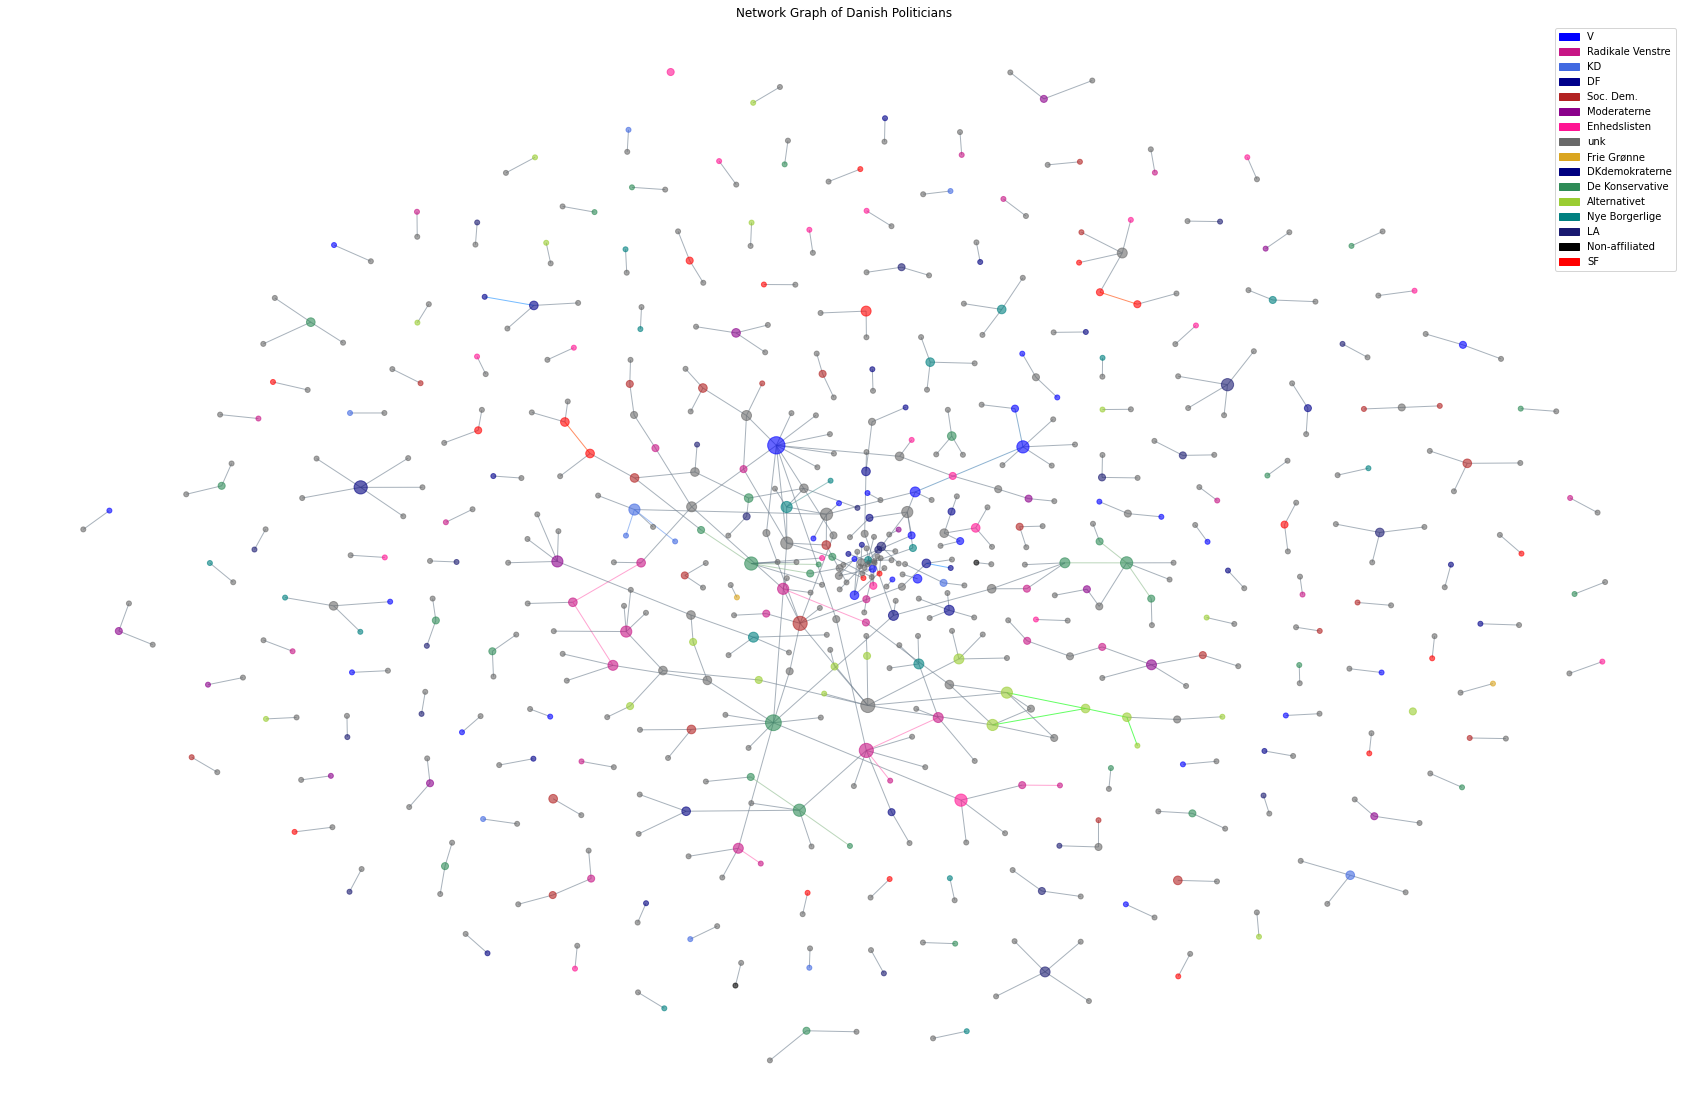

In [383]:
## Plotting network ## 
plt.figure(figsize = (30,20))

forceatlas2 = ForceAtlas2(
                        ## Behavior alternatives ##
                        outboundAttractionDistribution=False, # Dissuation
                        linLogMode=False,
                        adjustSizes=False, 
                        edgeWeightInfluence=1.0,

                        ## Performance ##
                        jitterTolerance=1.0,  # Tolerance level
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,

                        ## Tuning ##
                        scalingRatio=0.1,
                        strongGravityMode=False,
                        gravity=10.0,

                        ## Logging ##
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(G_visualize, pos=None, iterations=2000)

nx.draw_networkx(G_visualize, positions,nodelist=degree_dict.keys(), node_size=[v * 25 for v in degree_dict.values()], node_color = color_map_nodes,alpha = 0.6, edge_color = color_map_edge,with_labels=False, labels = color_map_legend.items())

plt.axis('off')
plt.title('Network Graph of Danish Politicians')
plt.legend(handles = handles_dict)
plt.show()

In [261]:
# Extract largest component
gcc = max(nx.weakly_connected_components(G), key=len)
gcc_subgraph = G.subgraph(gcc)
gcc_visualize = gcc_subgraph.to_undirected()

color_map_nodes, color_map_edge, degree_dict = color_maps(gcc_visualize, pol_spec = False)

  0%|          | 0/205 [00:00<?, ?it/s]

  0%|          | 0/217 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:03<00:00, 511.55it/s]


BarnesHut Approximation  took  0.63  seconds
Repulsion forces  took  3.04  seconds
Gravitational forces  took  0.05  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.10  seconds


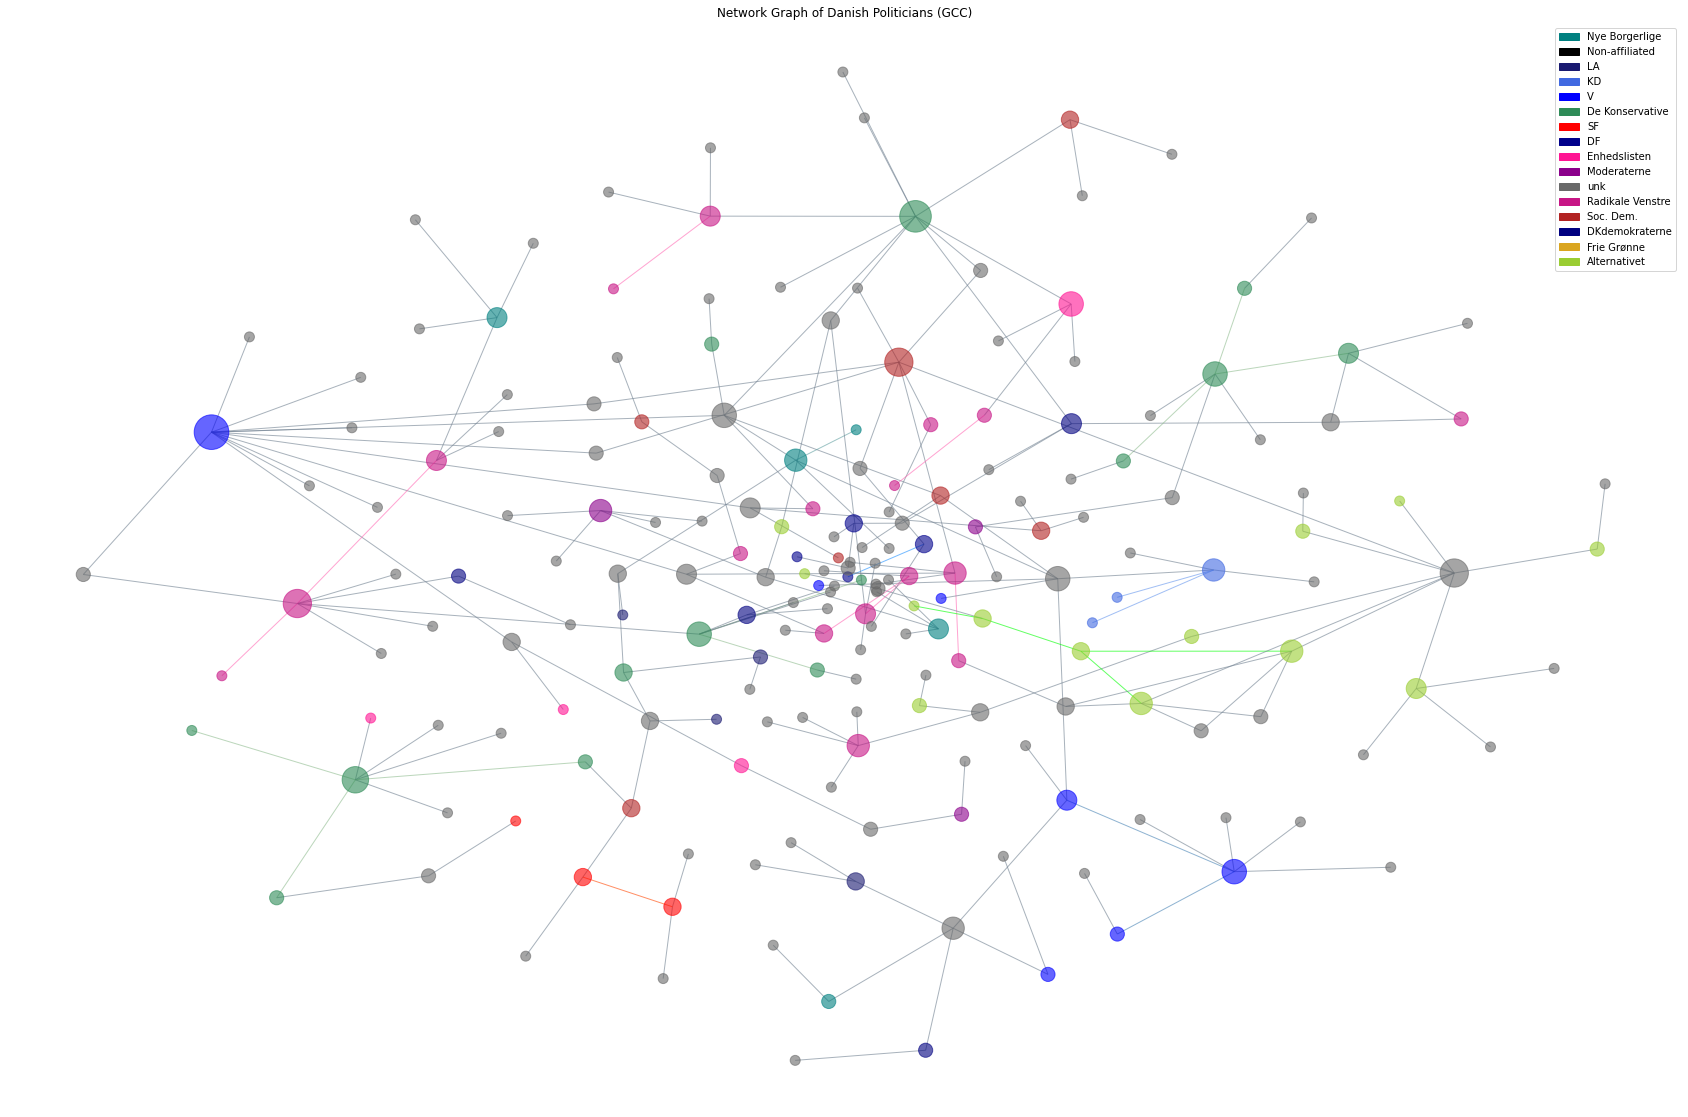

In [262]:
## Plotting network (GCC) ##
plt.figure(figsize = (30,20))

forceatlas2 = ForceAtlas2(
                        ## Behavior alternatives ##
                        outboundAttractionDistribution=False, # Dissuation
                        linLogMode=False,
                        adjustSizes=False, 
                        edgeWeightInfluence=1.0,

                        ## Performance ##
                        jitterTolerance=1.0,  # Tolerance level
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,

                        ## Tuning ##
                        scalingRatio=0.1,
                        strongGravityMode=False,
                        gravity=10.0,

                        ## Logging ##
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(gcc_visualize, pos=None, iterations=2000)

nx.draw_networkx(gcc_visualize, positions,nodelist=degree_dict.keys(), node_size=[v * 100 for v in degree_dict.values()], node_color = color_map_nodes,alpha = 0.6, edge_color = color_map_edge,with_labels=False, labels = color_map_legend.items())

plt.axis('off')
plt.title('Network Graph of Danish Politicians (GCC)')
plt.legend(handles = handles_dict)
plt.show()

In [263]:
print("Number of nodes in GCC:")
print(len(gcc_visualize.nodes))

Number of nodes in GCC:
205


In [264]:
print("Number of edges in GCC:")
print(len(gcc_visualize.edges))

Number of edges in GCC:
217


In [385]:
color_map_nodes, color_map_edge, degree_dict = color_maps(G_visualize, pol_spec = True)

  0%|          | 0/646 [00:00<?, ?it/s]

  0%|          | 0/490 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:16<00:00, 123.26it/s]


BarnesHut Approximation  took  2.59  seconds
Repulsion forces  took  12.85  seconds
Gravitational forces  took  0.18  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.41  seconds


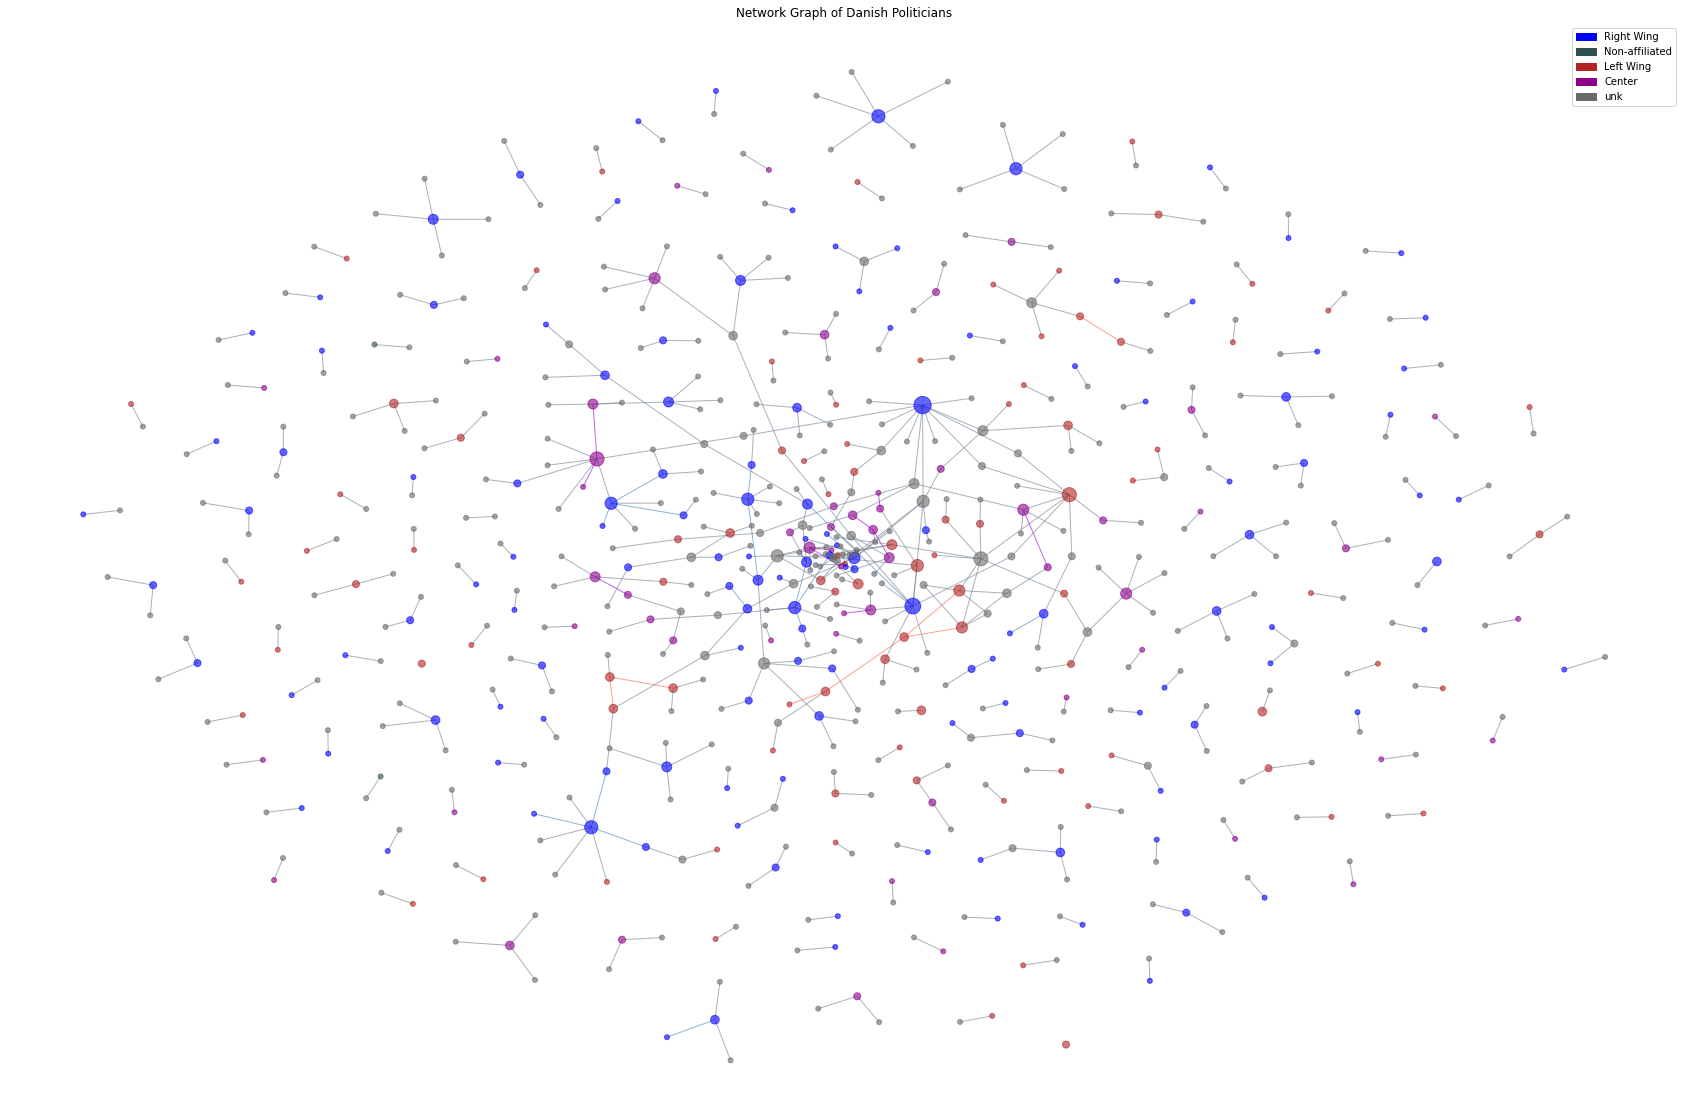

In [386]:
## Plotting network ## 
plt.figure(figsize = (30,20))

forceatlas2 = ForceAtlas2(
                        ## Behavior alternatives ##
                        outboundAttractionDistribution=False, # Dissuation
                        linLogMode=False,
                        adjustSizes=False, 
                        edgeWeightInfluence=1.0,

                        ## Performance ##
                        jitterTolerance=1.0,  # Tolerance level
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,

                        ## Tuning ##
                        scalingRatio=0.1,
                        strongGravityMode=False,
                        gravity=10.0,

                        ## Logging ##
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(G_visualize, pos=None, iterations=2000)

nx.draw_networkx(G_visualize, positions,nodelist=degree_dict.keys(), node_size=[v * 25 for v in degree_dict.values()], node_color = color_map_nodes,alpha = 0.6, edge_color = color_map_edge,with_labels=False, labels = color_map_legend_pol_spectrum.items())

plt.axis('off')
plt.title('Network Graph of Danish Politicians')
plt.legend(handles = handles_dict_pol_spec)
plt.show()

  0%|          | 0/205 [00:00<?, ?it/s]

  0%|          | 0/217 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:04<00:00, 489.17it/s]


BarnesHut Approximation  took  0.76  seconds
Repulsion forces  took  3.07  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.11  seconds


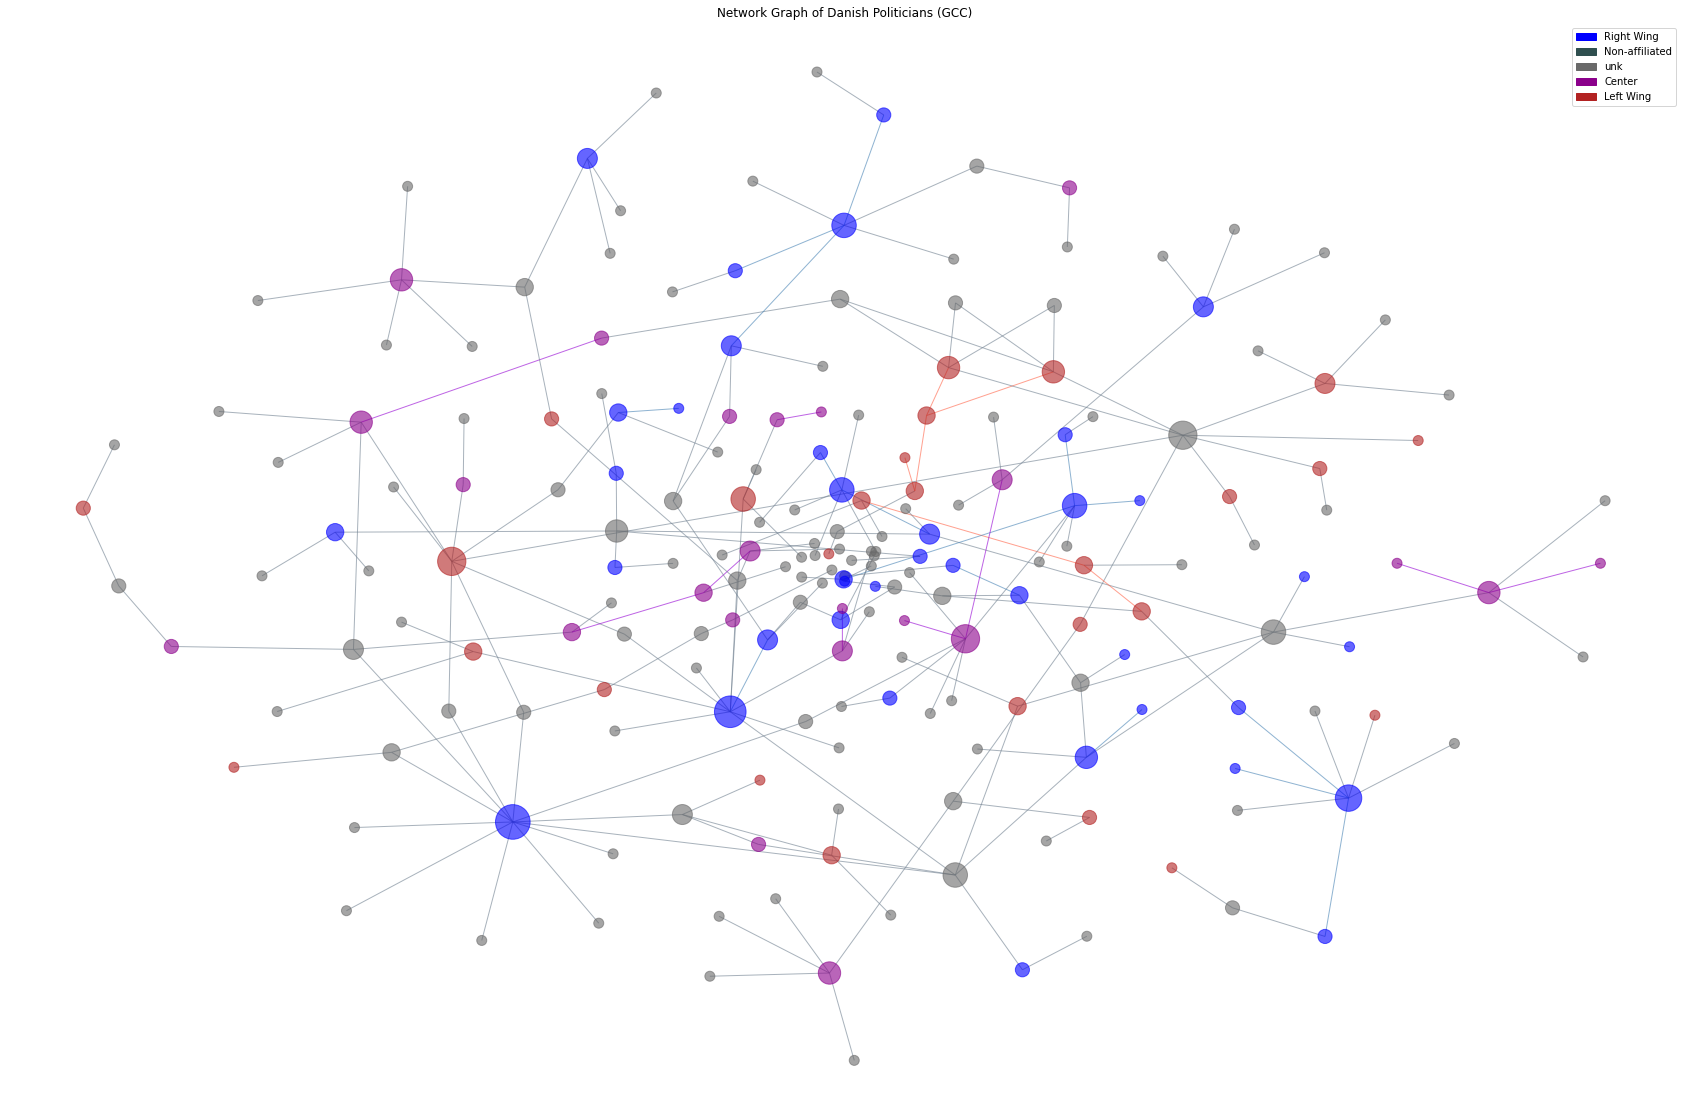

In [267]:
color_map_nodes, color_map_edge, degree_dict = color_maps(gcc_visualize, pol_spec = True)

## Plotting network (GCC) ##
plt.figure(figsize = (30,20))

forceatlas2 = ForceAtlas2(
                        ## Behavior alternatives ##
                        outboundAttractionDistribution=False, # Dissuation
                        linLogMode=False,
                        adjustSizes=False, 
                        edgeWeightInfluence=1.0,

                        ## Performance ##
                        jitterTolerance=1.0,  # Tolerance level
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,

                        ## Tuning ##
                        scalingRatio=0.1,
                        strongGravityMode=False,
                        gravity=10.0,

                        ## Logging ##
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(gcc_visualize, pos=None, iterations=2000)

nx.draw_networkx(gcc_visualize, positions,nodelist=degree_dict.keys(), node_size=[v * 100 for v in degree_dict.values()], node_color = color_map_nodes,alpha = 0.6, edge_color = color_map_edge,with_labels=False, labels = color_map_legend_pol_spectrum.items())

plt.axis('off')
plt.title('Network Graph of Danish Politicians (GCC)')
plt.legend(handles = handles_dict_pol_spec)
plt.show()

## Finding Communities

We start by cleaning the tweets of hyperlinks and HTML code, so that we can use it for visualizing wordclouds later

In [388]:
def get_links(tweet):
    """Find links in tweets and remove them.

        Args:
            tweet (str): The tweet to find links in.

        Returns:
            str: The cleaned tweet.
    """
    tweet = re.sub('\.*amp\.*', '', tweet.lower())
    
    return re.sub("(http|https)://[\w\-]+(\.[\w\-]+)+\S*",'', tweet)

In [389]:
# Apply function on all rows so that tweets are clean of any hyperlinks
tweets_w_mentions['tweet'] = tweets_w_mentions['tweet'].apply(get_links)

<ipython-input-389-b94dca208fc5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_w_mentions['tweet'] = tweets_w_mentions['tweet'].apply(get_links)


Tokenize tweets:

In [390]:
# Define stopwords
stop_words = set(stopwords.words('danish'))
tokenizer = RegexpTokenizer(r'\w+') 

def tweet_tokenizer(tweet):
    """Clean and tokenize tweet.

        Args:
            tweet (str): The tweet to clean and tokenize.

        Returns:
            str: The cleaned tweet.
    """
    wrd_tok = tokenizer.tokenize(tweet)
    
    # Set to lowercase and remove "RT" and "@" from tweets
    clean_tweet = [w.lower() for w in wrd_tok if not w.lower() in stop_words and not w.lower() in ['rt', '@', 'så', 'al','dkpol']]
    
    return clean_tweet

In [391]:
tweets_w_mentions['tokenized'] = tweets_w_mentions['tweet'].apply(tweet_tokenizer)

<ipython-input-391-dc711bb53213>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_w_mentions['tokenized'] = tweets_w_mentions['tweet'].apply(tweet_tokenizer)


In [392]:
def mention_remover(tweet, mentions):
    """Remove mentions from tweet.

        Args:
            tweet (str): The tweet to clean and tokenize.
            mentions (list): List of mentions to remove from tweet.

        Returns:
            str: The cleaned tweet.
    """
    for i in mentions:
        try:
            tweet.remove(i.lower())
        except:
            pass

In [393]:
tweets_w_mentions.apply(lambda x: mention_remover(x['tokenized'], x['mention']), axis=1)

0        None
1        None
3        None
4        None
5        None
         ... 
53335    None
53336    None
53337    None
53338    None
53340    None
Length: 40780, dtype: object

In [394]:
tweets_w_mentions.head(5)

tweetID     userID  \
0  1587190794502422528  606561223   
1  1587154827485782016  606561223   
3  1586771334872408064  606561223   
4  1586349096910061568  606561223   
5  1586262864192737280  606561223   

                                               tweet  user_handle party  \
0  rt @mettegjerskov: så er der klar tale fra de ...  LeaWermelin     A   
1  rt @verdensskove: sådan så det ud da @maivilla...  LeaWermelin     A   
3  rt @danmarksnatur: 85 procent af vælgerne støt...  LeaWermelin     A   
4  rt @idaauken: regeringen har været den mest mi...  LeaWermelin     A   
5  rt @danva1926: sikring af det rene drikkevand ...  LeaWermelin     A   

  pol_spectrum                                            mention  \
0    left wing                                    [MetteGjerskov]   
1    left wing  [verdensskove, MaiVilladsen, sofiecn, PiaOlsen...   
3    left wing                                    [DanmarksNatur]   
4    left wing           [IdaAuken, BirdLifeDanmark, LeaWermelin]   
5    left wing                                        [DANVA1926]   

                                           tokenized  
0  [klar, tale, blå, naturen, vigtigt, alligevel,...  
1                                    [modtog, lille]  
3  [85, procent, vælgerne, støtter, forbud, brug,...  
4       [regeringen, mest, miljøvenlige, tak, bravo]  
5  [sikring, rene, drikkevand, danskerne, fremtid...

In [395]:
tweets_w_mentions.tail(5)

tweetID      userID  \
53335  1401391375439044608  3300730179   
53336  1401386037860052992  3300730179   
53337  1401383460032352512  3300730179   
53338  1397834987446079488  3300730179   
53340   558551516962107392   479025309   

                                                   tweet user_handle party  \
53335  rt @hagbard_dane: jeg er færdig af grin. alvor...   line_aaen     Å   
53336  rt @alternativet_: “før jeg vil snakke om demo...   line_aaen     Å   
53337  rt @nhoerup: vi skal give familierne omsorg, s...   line_aaen     Å   
53338  @thedorteolsen enig! det er et problem at man ...   line_aaen     Å   
53340                                   @aboveandbeyond          one  UDEN   

      pol_spectrum                        mention  \
53335    left wing  [Hagbard_Dane, alternativet_]   
53336    left wing                [alternativet_]   
53337    left wing                [NHOERUP, Mira]   
53338    left wing                [TheDorteOlsen]   
53340         none               [aboveandbeyond]   

                                               tokenized  
53335  [færdig, grin, alvor, blandet, humor, måde, fo...  
53336  [før, snakke, demokrati, én, ting, bør, starte...  
53337  [give, familierne, omsorg, får, overskud, give...  
53338  [enig, problem, omtaler, personer, udstået, st...  
53340                                                 []

To identify communities within the network we grab the undirected version of the graph. The unsupervised Louvain algorithm is used for detecting the communities:

In [396]:
part = community_louvain.best_partition(G_visualize)

In [397]:
comms = np.unique(list(part.values()))

In [398]:
## Compute modularity for paritition ##

# Obtain representation of communities for nx_comm.modularity func
comms_dict = {}
for k, v in part.items():
    str_v_ = str(v)
    if str_v_ not in comms_dict.keys():
        comms_dict[str_v_] = [k]
    else:
        comms_dict[str_v_].append(k)

comms_list = [v for k,v in comms_dict.items()]

M = nx_comm.modularity(G_visualize, comms_list)

print('Partition modularity : {}'.format(M))

Partition modularity : 0.9498271553519397


In [399]:
print("Number of found communities:")
print(max(comms))

comm_3_n = [i for i in comms_list if len(i) >=3]

print('Number of communities with more than 3 nodes: {}'.format(len(comm_3_n)))

Number of found communities:
184
Number of communities with more than 3 nodes: 62


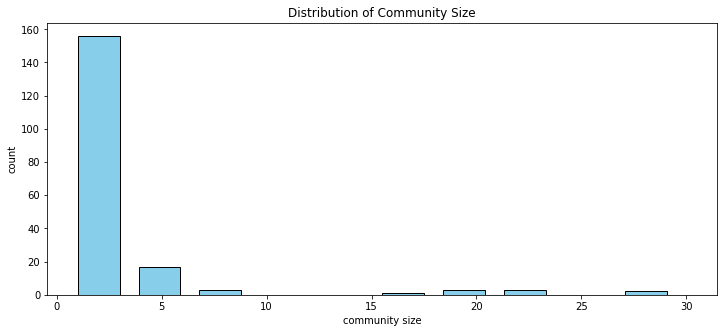

In [400]:
comms_sizes = [len(i) for i in comms_list]

plt.figure(figsize=(12,5))
plt.hist(comms_sizes,width=2,color='skyblue',edgecolor='k')
plt.xlabel('community size')
plt.ylabel('count')
plt.title('Distribution of Community Size')
plt.show()

In [402]:
# Reorganizing into dict
d_input = dict(part.items())
res = {}

for i, v in d_input.items():
    res[v] = [i] if v not in res.keys() else res[v] + [i]

Extracting the 16 largest communities:

In [403]:
c = 0
top_comms = sorted(res.items(), key=lambda v: len(v[1]), reverse=True)[:16]
comm_tweets = []

for i,t in enumerate(top_comms):
    comm_tweets.append(np.concatenate(tweets_w_mentions.loc[tweets_w_mentions['user_handle'].isin(t[1])]['tokenized'].values))
    
    print(f"Community {i+1}. Size: {len(t[1])}")
    c += len(t[1])
    
print(f"\nCirca {int(np.round(c/len(G_visualize.nodes), 2)*100)}% of network nodes represented in these partitions.")

Community 1. Size: 30
Community 2. Size: 30
Community 3. Size: 24
Community 4. Size: 23
Community 5. Size: 22
Community 6. Size: 21
Community 7. Size: 19
Community 8. Size: 19
Community 9. Size: 17
Community 10. Size: 9
Community 11. Size: 8
Community 12. Size: 7
Community 13. Size: 6
Community 14. Size: 5
Community 15. Size: 5
Community 16. Size: 5

Circa 39% of network nodes represented in these partitions.


**Inspect Party Affiliation of Users in Top Nodes**

In [404]:
def get_parties(comm_users_list):
    """Get list of party affiliation for users in community.

        Args:
            comm_users_list (list): The list of users in a community.

        Returns:
            list: List of party affiliation of each user in community.
    """
    parties = []
    for i in comm_users_list:
        parties.append(nx.get_node_attributes(G_visualize, 'party')[i])
    
    return parties

In [406]:
def unique_and_count(parties_list):
    """Get list of unique parties in list of users in community and their respective counts in list also.

        Args:
            parties_list (list): Output from get_parties(), list of party affiliation of each user in community.

        Returns:
            list: List of unique parties present in community.
            list: Count of party occurence.
    """
    x = np.array(parties_list)
    unique_list = list(np.unique(x))
    
    count_list = []
    for i in unique_list:
        count = parties_list.count(i)
        count_list.append(count)
        
    return unique_list, count_list

color_dict = {"firebrick": "A", "mediumvioletred": "B", "seagreen": "C", "teal": "D", "red": "F", "midnightblue": "I", 
              "royalblue": "K", "darkmagenta": "M", "darkblue": "O", "goldenrod": "Q", "blue": "V", "navy": "Æ",
              "deeppink": "Ø", "yellowgreen": "Å", "black": 'UDEN', "dimgray": "unk"}

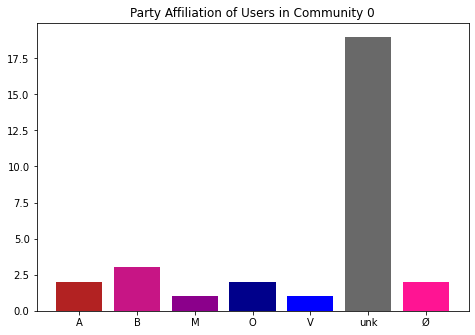

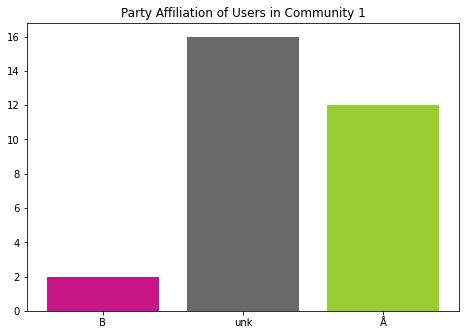

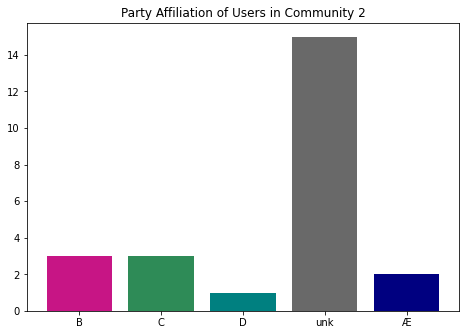

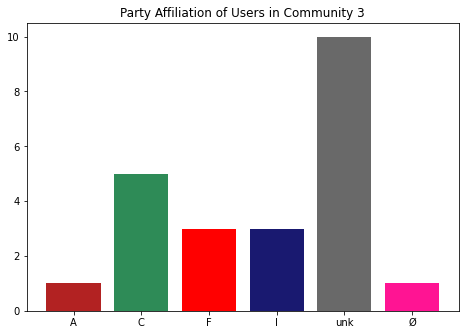

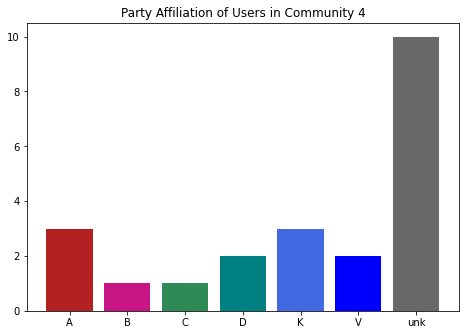

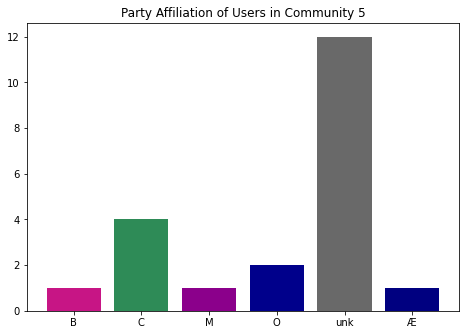

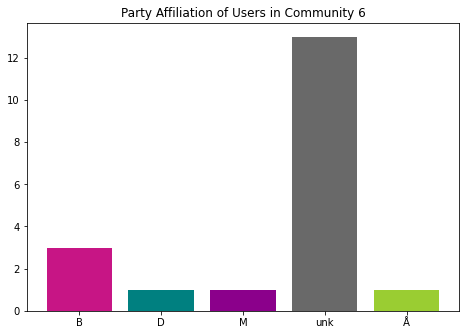

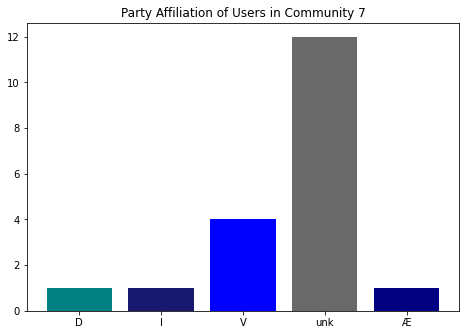

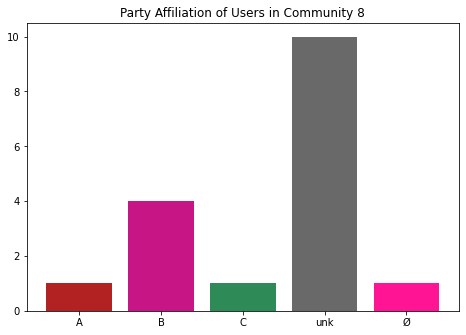

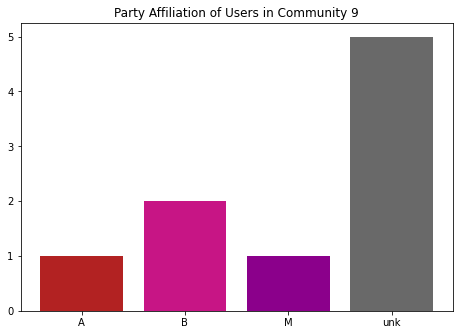

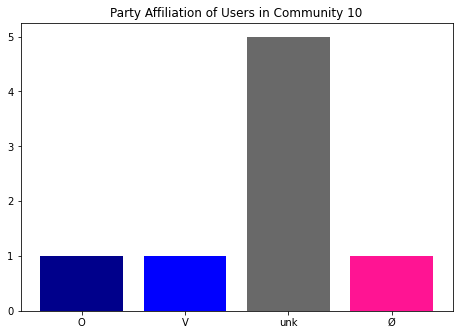

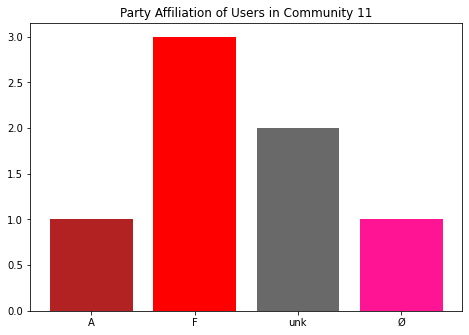

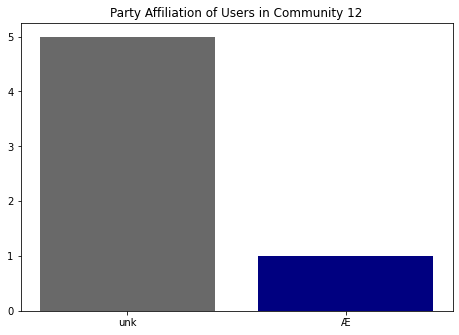

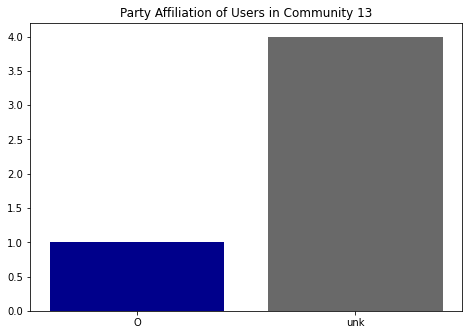

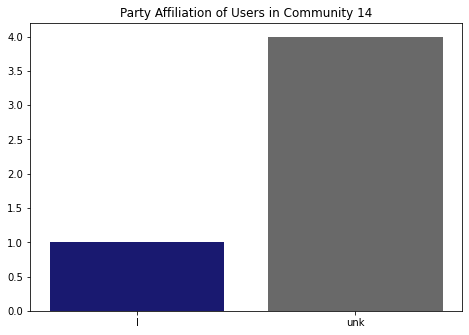

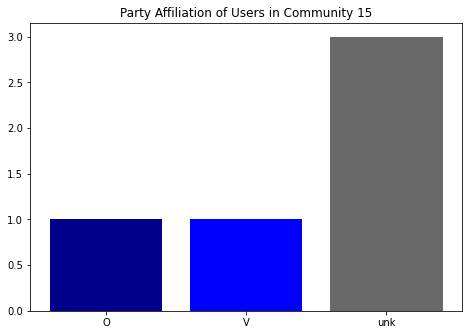

In [407]:
for i, _ in enumerate(top_comms):
    unique_list, count_list = unique_and_count(get_parties(top_comms[i][1]))
    party_aff_plot(unique_list, count_list, f"Party Affiliation of Users in Community {i}", color_dict)

In [408]:
for i, _ in enumerate(top_comms):
    print(f"Parties in Community {i+1}:")
    unique_list, count_list = unique_and_count(get_parties(top_comms[i][1]))
    print(dict(zip(unique_list, count_list)))
    print(" ")

Parties in Community 1:
{'A': 2, 'B': 3, 'M': 1, 'O': 2, 'V': 1, 'unk': 19, 'Ø': 2}
 
Parties in Community 2:
{'B': 2, 'unk': 16, 'Å': 12}
 
Parties in Community 3:
{'B': 3, 'C': 3, 'D': 1, 'unk': 15, 'Æ': 2}
 
Parties in Community 4:
{'A': 1, 'C': 5, 'F': 3, 'I': 3, 'unk': 10, 'Ø': 1}
 
Parties in Community 5:
{'A': 3, 'B': 1, 'C': 1, 'D': 2, 'K': 3, 'V': 2, 'unk': 10}
 
Parties in Community 6:
{'B': 1, 'C': 4, 'M': 1, 'O': 2, 'unk': 12, 'Æ': 1}
 
Parties in Community 7:
{'B': 3, 'D': 1, 'M': 1, 'unk': 13, 'Å': 1}
 
Parties in Community 8:
{'D': 1, 'I': 1, 'V': 4, 'unk': 12, 'Æ': 1}
 
Parties in Community 9:
{'A': 1, 'B': 4, 'C': 1, 'unk': 10, 'Ø': 1}
 
Parties in Community 10:
{'A': 1, 'B': 2, 'M': 1, 'unk': 5}
 
Parties in Community 11:
{'O': 1, 'V': 1, 'unk': 5, 'Ø': 1}
 
Parties in Community 12:
{'A': 1, 'F': 3, 'unk': 2, 'Ø': 1}
 
Parties in Community 13:
{'unk': 5, 'Æ': 1}
 
Parties in Community 14:
{'O': 1, 'unk': 4}
 
Parties in Community 15:
{'I': 1, 'unk': 4}
 
Parties in Co

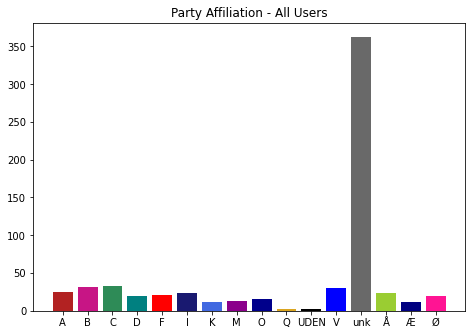

In [409]:
unique_list, count_list = unique_and_count(list(nx.get_node_attributes(G_visualize,'party').values()))
party_aff_plot(unique_list, count_list, "Party Affiliation - All Users", color_dict)

In [410]:
print(dict(zip(unique_list, count_list)))

{'A': 25, 'B': 32, 'C': 33, 'D': 19, 'F': 21, 'I': 24, 'K': 11, 'M': 13, 'O': 16, 'Q': 2, 'UDEN': 2, 'V': 30, 'unk': 363, 'Å': 23, 'Æ': 12, 'Ø': 20}


**Visualizing TF-IDF Word Clouds for Top 16 Communities**

In [411]:
# Calculate TF
tf_tweets = pd.Series(comm_tweets).apply(nltk.FreqDist)

In [412]:
# Compute document frequency
d_freq = nltk.FreqDist(np.concatenate(pd.Series(comm_tweets).apply(lambda x: list(set(x))).values))

In [413]:
# Compute IDF
N = 16
idf_vals = np.log10(((1+N)/(1+np.array(list(d_freq.values()))))) + 1

In [414]:
idf = dict(zip(d_freq.keys(), idf_vals))

In [415]:
def tf_idf(tf, idf):
    """Compute TF-IDF
    """
    return dict(zip(list(tf.keys()), np.array(list(tf.values()))*np.array([idf.get(w) for w in list(tf.keys())])))

In [416]:
series_TF_IDF = pd.Series(tf_tweets).apply(lambda x: tf_idf(x, idf))

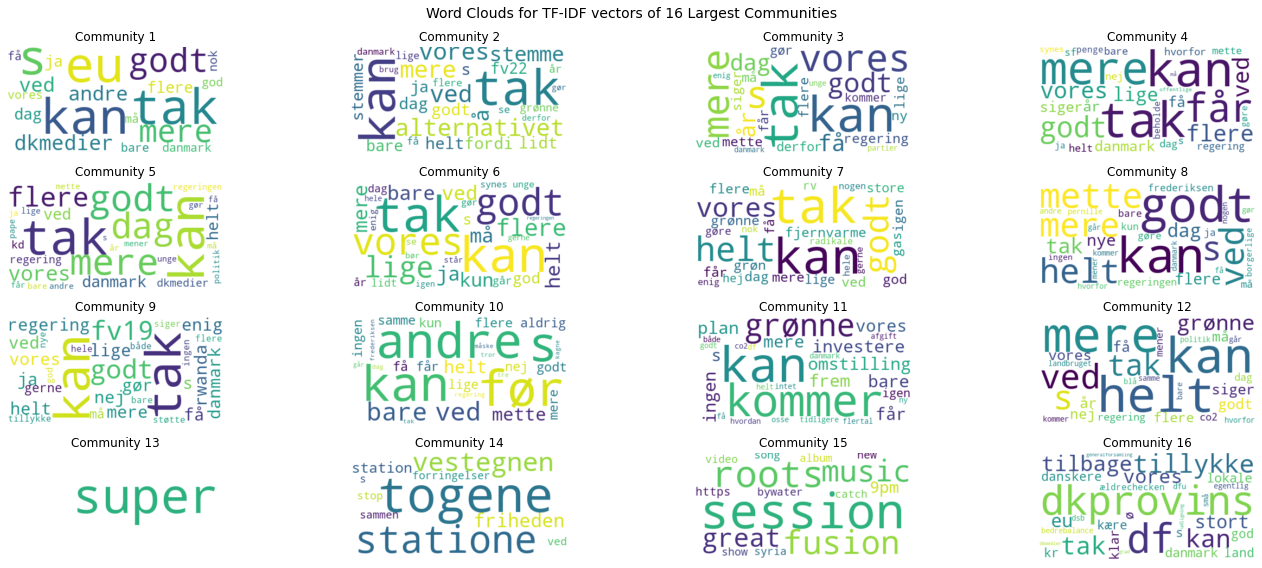

In [417]:
fig, ax = plt.subplots(4, 4, figsize= (20, 8))

c = 0
for i in range(4):
    for j in range(4):
        w_list = sorted(series_TF_IDF[c], key=series_TF_IDF[c].get, reverse=True)[:30]
        wordcloud = WordCloud(max_font_size=90, max_words=30, background_color="white").generate(" ".join(w_list))
        ax[i][j].imshow(wordcloud, interpolation="bilinear")
        ax[i][j].set_axis_off()
        ax[i][j].set_title(f"Community {c+1}")
        c += 1
        
fig.suptitle("Word Clouds for TF-IDF vectors of 16 Largest Communities", fontsize = 14)
fig.tight_layout()
plt.show()

**Visualizing Community in Network**

In [418]:
# Reorganizing partition into dict structure
par_class = set(part.values())
par_class_dict = {}

for v in part.values():
    str_v = str(v)
    
    if str_v not in par_class_dict.keys():
        par_class_dict[str_v] = 1
    else:
        par_class_dict[str_v] += 1

In [419]:
# Getting top 16, again
par_class_dict = {k: v for k, v in sorted(par_class_dict.items(), key=lambda item: item[1],reverse = True)}
par_name_top16 = list(par_class_dict.keys())[:16]

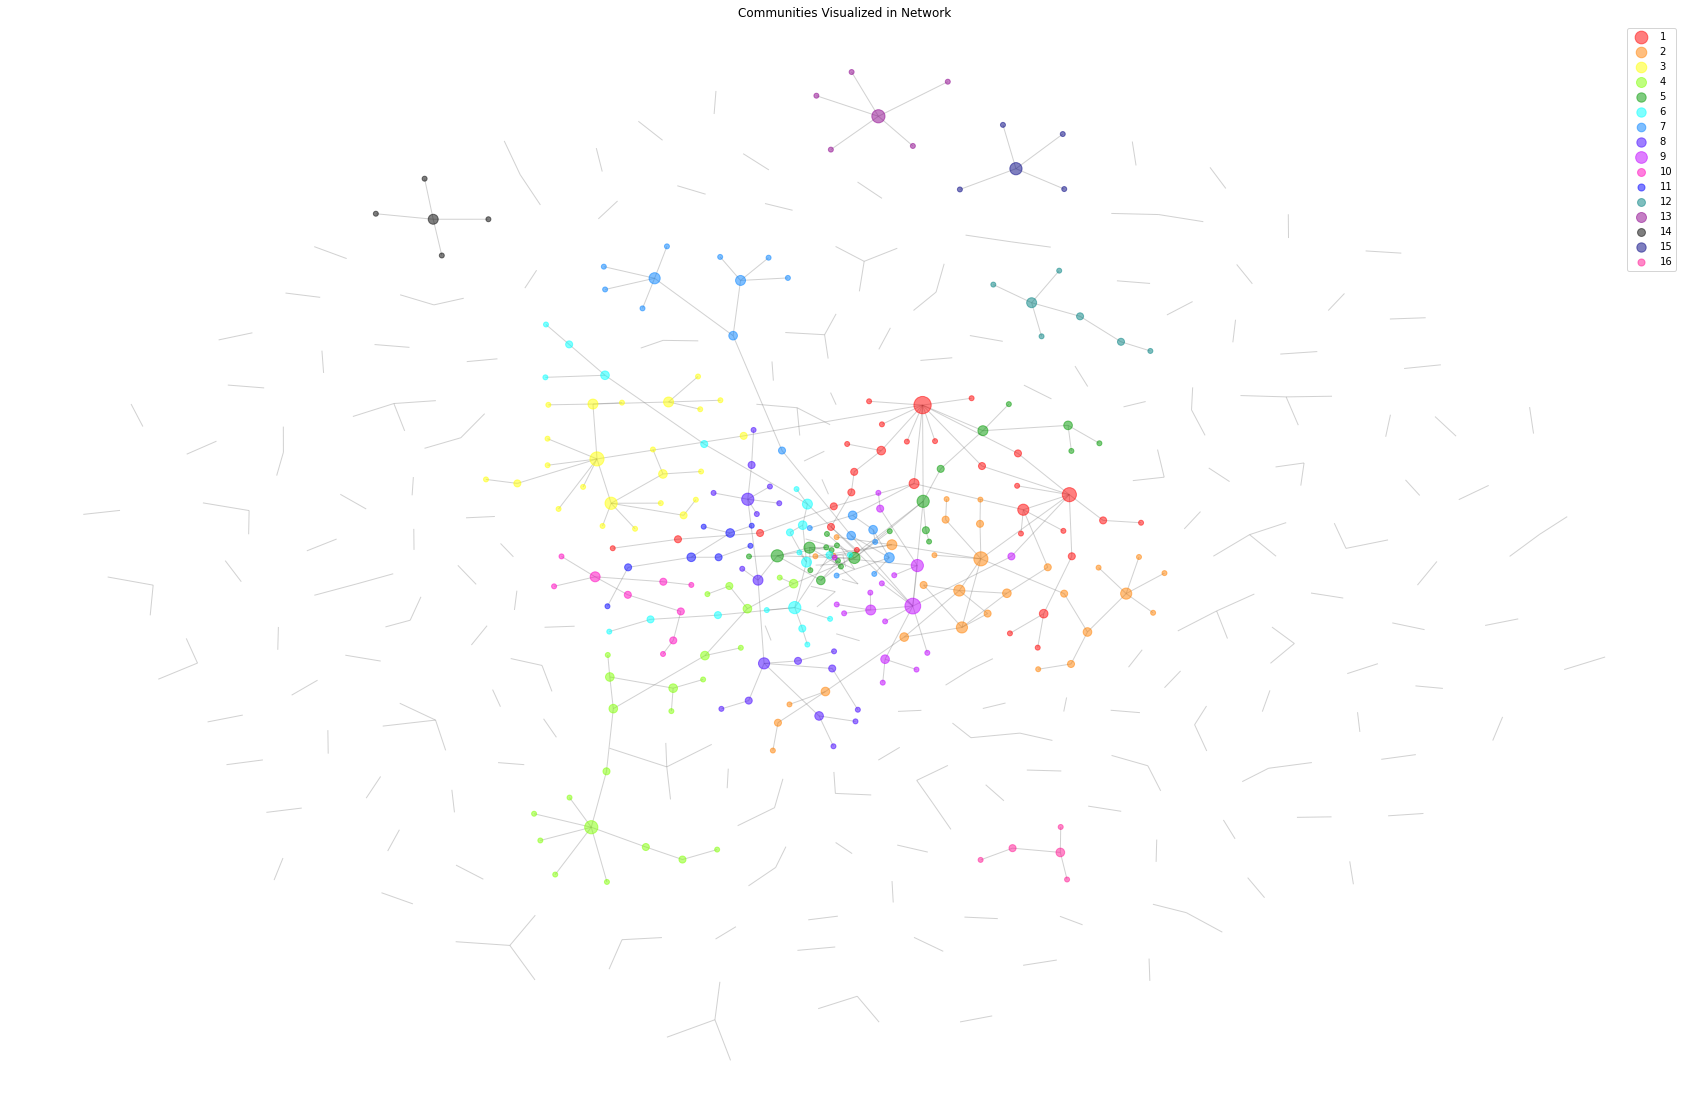

In [420]:
# Plot each community in network
plt.figure(figsize = (30,20))

nx.draw_networkx_edges(G_visualize,positions, alpha=0.3, edge_color = 'dimgray')

node_color_list = ['#ff0000','#ff8000','#ffff00','#80ff00',\
                   '#009900','#00ffff','#0080ff','#4000ff',\
                  '#bf00ff','#ff00bf', "blue", "teal", "darkmagenta", "black", "navy", "deeppink"]

for i,par_class in enumerate(par_name_top16):
    nodes = [n for n in list(G_visualize.nodes()) if part[n] == int(par_class)]
    d = dict(G_visualize.degree(nodes))
    nx.draw_networkx_nodes(G_visualize, positions, d.keys(), node_size=[v*25 for v in d.values()],
                       node_color=node_color_list[i],alpha = 0.5,label =i+1)

plt.legend()   
plt.axis('off')
plt.title("Communities Visualized in Network")
plt.show()   

## Degree Centrality

To investigate degree centrality, we revert back to the directed version of the network graph.

In [424]:
# 5 most central characters according to degree centrality
in_degree_c = nx.in_degree_centrality(G)
out_degree_c = nx.out_degree_centrality(G)

# get the first 5 with in degree centrality
in_degree_c_sorted  = sorted(in_degree_c.items(),key = lambda x:x[1],reverse = True)
print('5 most central users (in degree centrality):\n{}'.format(in_degree_c_sorted[0:5]))
print('\n')

# get the first 5 with out degree centrality
out_degree_c_sorted  = sorted(out_degree_c.items(),key = lambda x:x[1],reverse = True)
print('5 most central users (out degree centrality):\n{}'.format(out_degree_c_sorted[0:5]))

0.0
5 most central users (in degree centrality):
[('alternativet_', 0.012403100775193798), ('KonservativeDK', 0.009302325581395349), ('venstredk', 0.009302325581395349), ('berlingske', 0.007751937984496124), ('metteabildgaard', 0.006201550387596899)]


5 most central users (out degree centrality):
[('MarleneAmbo', 0.018604651162790697), ('Scheelsbeck', 0.015503875968992248), ('AneHalsboe', 0.010852713178294573), ('hannebjornk', 0.009302325581395349), ('PLindhoutTravel', 0.009302325581395349)]


In [457]:
in_deg_A = []
in_deg_B = []
in_deg_C = []
in_deg_D = []
in_deg_F = []
in_deg_I = []
in_deg_K = []
in_deg_M = []
in_deg_O = []
in_deg_Q = []
in_deg_V = []
in_deg_Æ = []
in_deg_Ø = []
in_deg_Å = []
in_deg_UDEN = []

out_deg_A = []
out_deg_B = []
out_deg_C = []
out_deg_D = []
out_deg_F = []
out_deg_I = []
out_deg_K = []
out_deg_M = []
out_deg_O = []
out_deg_Q = []
out_deg_V = []
out_deg_Æ = []
out_deg_Ø = []
out_deg_Å = []
out_deg_UDEN = []

# Define colors for all parties
for node in tqdm(list(G.nodes())):
    if nx.get_node_attributes(G,'party')[node] == 'A': # Soc. Dem.
        in_deg_A.append(in_degree_c[node])
        out_deg_A.append(out_degree_c[node])

    elif nx.get_node_attributes(G,'party')[node] == 'B': # Radikale venstre
        in_deg_B.append(in_degree_c[node])
        out_deg_B.append(out_degree_c[node])

    elif nx.get_node_attributes(G,'party')[node] == 'C': # Konservative
        in_deg_C.append(in_degree_c[node])
        out_deg_C.append(out_degree_c[node])

    elif nx.get_node_attributes(G,'party')[node] == 'D': # Nye Borgerlige
        in_deg_D.append(in_degree_c[node])
        out_deg_D.append(out_degree_c[node])

    elif nx.get_node_attributes(G,'party')[node] == 'F': # SF
        in_deg_F.append(in_degree_c[node])
        out_deg_F.append(out_degree_c[node])

    elif nx.get_node_attributes(G,'party')[node] == 'I': # LA
        in_deg_I.append(in_degree_c[node])
        out_deg_I.append(out_degree_c[node])

    elif nx.get_node_attributes(G,'party')[node] == 'K': # KD
        in_deg_K.append(in_degree_c[node])
        out_deg_K.append(out_degree_c[node])

    elif nx.get_node_attributes(G,'party')[node] == 'M': # Moderaterne
        in_deg_M.append(in_degree_c[node])
        out_deg_M.append(out_degree_c[node])

    elif nx.get_node_attributes(G,'party')[node] == 'O': # DF
        in_deg_O.append(in_degree_c[node])
        out_deg_O.append(out_degree_c[node])

    elif nx.get_node_attributes(G,'party')[node] == 'Q': # Frie grønne
        in_deg_Q.append(in_degree_c[node])
        out_deg_Q.append(out_degree_c[node])

    elif nx.get_node_attributes(G,'party')[node] == 'V': # Venstre
        in_deg_V.append(in_degree_c[node])
        out_deg_V.append(out_degree_c[node])

    elif nx.get_node_attributes(G,'party')[node] == 'Æ': # DK demokraterne
        in_deg_Æ.append(in_degree_c[node])
        out_deg_Æ.append(out_degree_c[node])

    elif nx.get_node_attributes(G,'party')[node] == 'Ø': # Enhedslisten
        in_deg_Ø.append(in_degree_c[node])
        out_deg_Ø.append(out_degree_c[node])

    elif nx.get_node_attributes(G,'party')[node] == 'Å': # Alternativet
        in_deg_Å.append(in_degree_c[node])
        out_deg_Å.append(out_degree_c[node])

    elif nx.get_node_attributes(G,'party')[node] == 'UDEN':
        in_deg_UDEN.append(in_degree_c[node])
        out_deg_UDEN.append(out_degree_c[node])

  0%|          | 0/646 [00:00<?, ?it/s]

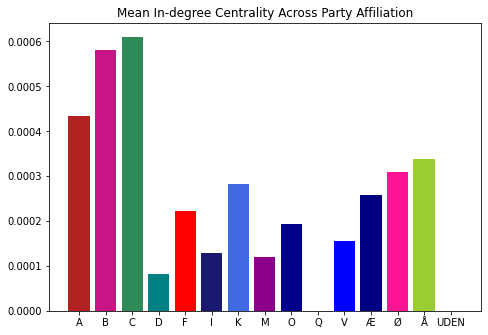

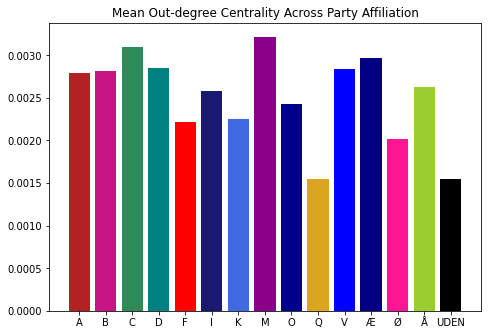

In [458]:
party_aff_plot(unique_parties_lst, [np.mean(in_deg_A), np.mean(in_deg_B), np.mean(in_deg_C), np.mean(in_deg_D), np.mean(in_deg_F), np.mean(in_deg_I), np.mean(in_deg_K), np.mean(in_deg_M), np.mean(in_deg_O), np.mean(in_deg_Q), np.mean(in_deg_V), np.mean(in_deg_Æ), np.mean(in_deg_Ø), np.mean(in_deg_Å), np.mean(in_deg_UDEN)], "Mean In-degree Centrality Across Party Affiliation",color_dict_)
party_aff_plot(unique_parties_lst, [np.mean(out_deg_A), np.mean(out_deg_B), np.mean(out_deg_C), np.mean(out_deg_D), np.mean(out_deg_F), np.mean(out_deg_I), np.mean(out_deg_K), np.mean(out_deg_M), np.mean(out_deg_O), np.mean(out_deg_Q), np.mean(out_deg_V), np.mean(out_deg_Æ), np.mean(out_deg_Ø), np.mean(out_deg_Å), np.mean(out_deg_UDEN)], "Mean Out-degree Centrality Across Party Affiliation",color_dict_)

In [479]:
def plot_force_directed_graph(Graph, node_size_dict, fivemost_nodes, title_text, node_scale):
    """Make Force Atlas 2 directed graph plot of network with five most central nodes plotted.

        Args:
            Graph (NetworkX Graph object): NetworkX graph to plot.
            node_size_dict (dict): Dictionary of all nodes with value as node size and key for node name.
            fivemost_nodes (dict): Dictionary of five most central nodes with value as node size and key for node name.
            title_text (str): Title for plot.
            node_scale (int): Scaling factor for plotting the nodes.

    """
    # Get color maps from color_maps() function
    color_map_nodes, color_map_edge, degree_dict = color_maps(Graph, pol_spec = False)
    
    plt.figure(figsize = (30,20))

    forceatlas2 = ForceAtlas2(
                        ## Behavior alternatives ##
                        outboundAttractionDistribution=False,  # Dissuation
                        linLogMode=False,
                        adjustSizes=False,
                        edgeWeightInfluence=1.0,

                        ## Performance ##
                        jitterTolerance=1.0, # Tolerance level
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,

                        ## Tuning ##
                        scalingRatio=0.1,
                        strongGravityMode=False,
                        gravity=10.0,

                        ## Logging ##
                        verbose=True)

    positions = forceatlas2.forceatlas2_networkx_layout(Graph, pos=None, iterations=2000)
    
    nx.draw_networkx(Graph, positions,nodelist=list(node_size_dict.keys()), node_size=[v * node_scale for v in node_size_dict.values()], alpha = 0.6,\
                        node_color = color_map_nodes,edge_color = color_map_edge,with_labels=False)
    
    nx.draw_networkx_nodes(Graph, positions, nodelist=list(fivemost_nodes.keys()),node_size=[v * node_scale for v in fivemost_nodes.values()], \
                           alpha = 1, node_color="#EA3C0D",edgecolors ='black')
    labels = {}
    for node in fivemost_nodes.keys():
        labels[node] = node
    
    nx.draw_networkx_labels(Graph,positions,labels,font_size=18,font_color='k')
    
    plt.title(title_text,fontsize=28)
    plt.axis('off')
    plt.legend(handles = handles_dict)
    plt.show()

  0%|          | 0/646 [00:00<?, ?it/s]

  0%|          | 0/490 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:16<00:00, 117.74it/s]


BarnesHut Approximation  took  2.86  seconds
Repulsion forces  took  13.43  seconds
Gravitational forces  took  0.06  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.40  seconds


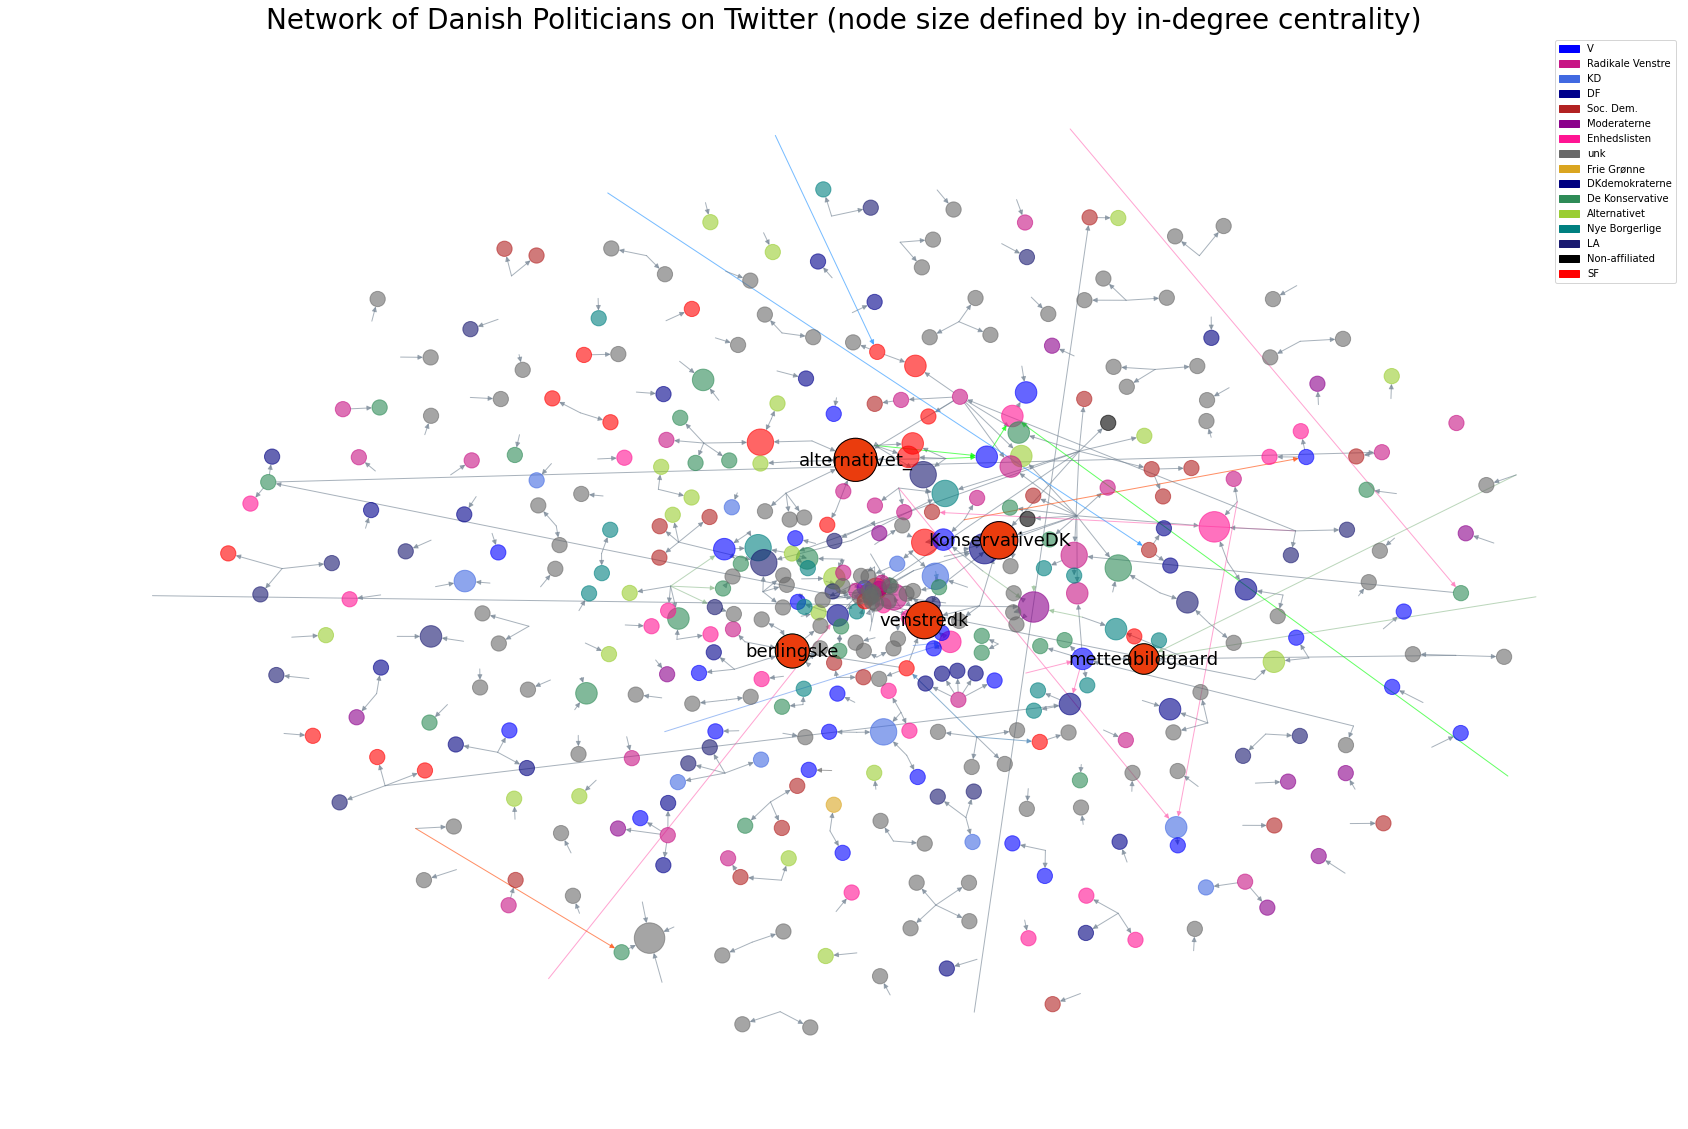

In [480]:
# Plot the network with in-degree centrality
in_degree_c_sorted = sorted(in_degree_c.items(),key = lambda x:x[1],reverse = True)
in_degree_c_sorted = dict(in_degree_c_sorted)
in_degree_c_sorted.update((x, y*10000) for x, y in in_degree_c_sorted.items())

# 5 most central users
nodes_ = list(in_degree_c_sorted)[0:5]
fivemost_nodes = {}
for i in nodes_:
    fivemost_nodes[i] = in_degree_c_sorted[i]

title_text = 'Network of Danish Politicians on Twitter (node size defined by in-degree centrality)'

plot_force_directed_graph(G, in_degree_c_sorted,fivemost_nodes,title_text, 15)

  0%|          | 0/646 [00:00<?, ?it/s]

  0%|          | 0/490 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:17<00:00, 115.85it/s]


BarnesHut Approximation  took  2.97  seconds
Repulsion forces  took  13.72  seconds
Gravitational forces  took  0.09  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.28  seconds


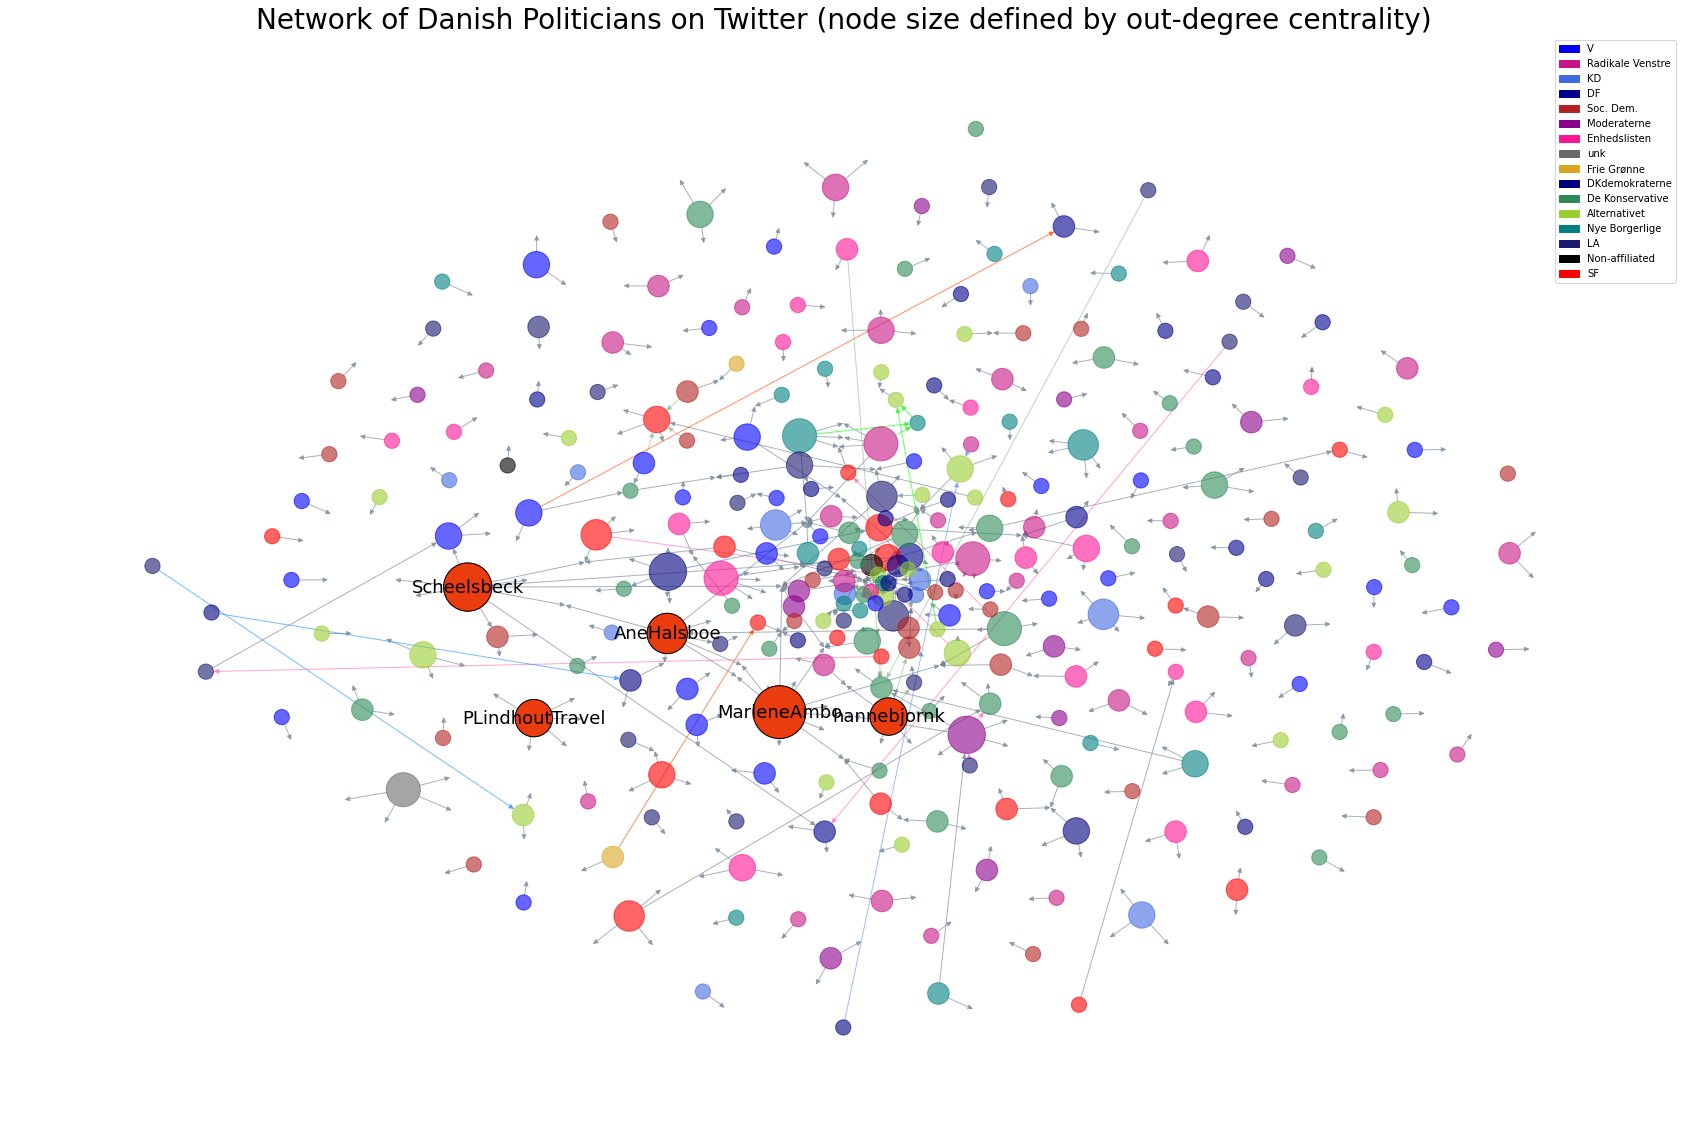

In [481]:
# Plot the network with in-degree centrality
out_degree_c_sorted = sorted(out_degree_c.items(),key = lambda x:x[1],reverse = True)
out_degree_c_sorted = dict(out_degree_c_sorted)
out_degree_c_sorted.update((x, y*10000) for x, y in out_degree_c_sorted.items())

# 5 most central users
nodes_ = list(out_degree_c_sorted)[0:5]

fivemost_nodes = {}
for i in nodes_:
    fivemost_nodes[i] = out_degree_c_sorted[i]

title_text = 'Network of Danish Politicians on Twitter (node size defined by out-degree centrality)'

plot_force_directed_graph(G, out_degree_c_sorted,fivemost_nodes,title_text, 15)

**Betweenness Centrality for Undirected Graph**

In [474]:
between_c = nx.betweenness_centrality(G_visualize)

In [476]:
in_deg_A = []
in_deg_B = []
in_deg_C = []
in_deg_D = []
in_deg_F = []
in_deg_I = []
in_deg_K = []
in_deg_M = []
in_deg_O = []
in_deg_Q = []
in_deg_V = []
in_deg_Æ = []
in_deg_Ø = []
in_deg_Å = []
in_deg_UDEN = []

# Define colors for all parties
for node in tqdm(list(G.nodes())):
    if nx.get_node_attributes(G,'party')[node] == 'A': # Soc. Dem.
        in_deg_A.append(between_c[node])

    elif nx.get_node_attributes(G,'party')[node] == 'B': # Radikale venstre
        in_deg_B.append(between_c[node])

    elif nx.get_node_attributes(G,'party')[node] == 'C': # Konservative
        in_deg_C.append(between_c[node])

    elif nx.get_node_attributes(G,'party')[node] == 'D': # Nye Borgerlige
        in_deg_D.append(between_c[node])

    elif nx.get_node_attributes(G,'party')[node] == 'F': # SF
        in_deg_F.append(between_c[node])

    elif nx.get_node_attributes(G,'party')[node] == 'I': # LA
        in_deg_I.append(between_c[node])

    elif nx.get_node_attributes(G,'party')[node] == 'K': # KD
        in_deg_K.append(between_c[node])

    elif nx.get_node_attributes(G,'party')[node] == 'M': # Moderaterne
        in_deg_M.append(between_c[node])

    elif nx.get_node_attributes(G,'party')[node] == 'O': # DF
        in_deg_O.append(between_c[node])

    elif nx.get_node_attributes(G,'party')[node] == 'Q': # Frie grønne
        in_deg_Q.append(between_c[node])

    elif nx.get_node_attributes(G,'party')[node] == 'V': # Venstre
        in_deg_V.append(between_c[node])

    elif nx.get_node_attributes(G,'party')[node] == 'Æ': # DK demokraterne
        in_deg_Æ.append(between_c[node])

    elif nx.get_node_attributes(G,'party')[node] == 'Ø': # Enhedslisten
        in_deg_Ø.append(between_c[node])

    elif nx.get_node_attributes(G,'party')[node] == 'Å': # Alternativet
        in_deg_Å.append(between_c[node])

    elif nx.get_node_attributes(G,'party')[node] == 'UDEN':
        in_deg_UDEN.append(between_c[node])

  0%|          | 0/646 [00:00<?, ?it/s]

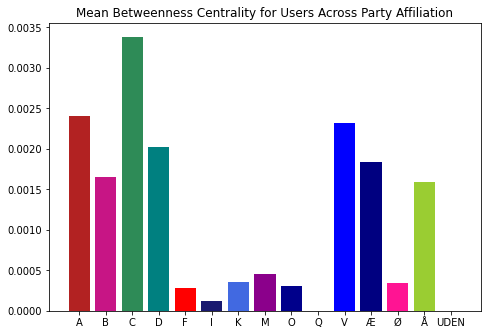

In [478]:
party_aff_plot(unique_parties_lst, [np.mean(in_deg_A), np.mean(in_deg_B), np.mean(in_deg_C), np.mean(in_deg_D), np.mean(in_deg_F), np.mean(in_deg_I), np.mean(in_deg_K), np.mean(in_deg_M), np.mean(in_deg_O), np.mean(in_deg_Q), np.mean(in_deg_V), np.mean(in_deg_Æ), np.mean(in_deg_Ø), np.mean(in_deg_Å), np.mean(in_deg_UDEN)], "Mean Betweenness Centrality for Users Across Party Affiliation",color_dict_)

In [475]:
# the 5 most central characters according to betweenness centrality
bet_c_sorted  = sorted(between_c.items(),key = lambda x:x[1],reverse = True)
print('5 most central characters (betweenness centrality):\n{}'.format(bet_c_sorted[0:5]))
print('\n')

5 most central characters (betweenness centrality):
[('KonservativeDK', 0.0529945270996838), ('Scheelsbeck', 0.04526152759722021), ('MarleneAmbo', 0.04521105172773526), ('PernilleVermund', 0.03152294284751312), ('AneHalsboe', 0.030662686375527617)]




In [482]:
# Scale for better plotting
bet_c_sorted = dict(bet_c_sorted)
bet_c_sorted.update((x, y*100000) for x, y in between_c.items())

  0%|          | 0/646 [00:00<?, ?it/s]

  0%|          | 0/490 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:16<00:00, 124.39it/s]


BarnesHut Approximation  took  2.72  seconds
Repulsion forces  took  12.70  seconds
Gravitational forces  took  0.10  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.32  seconds


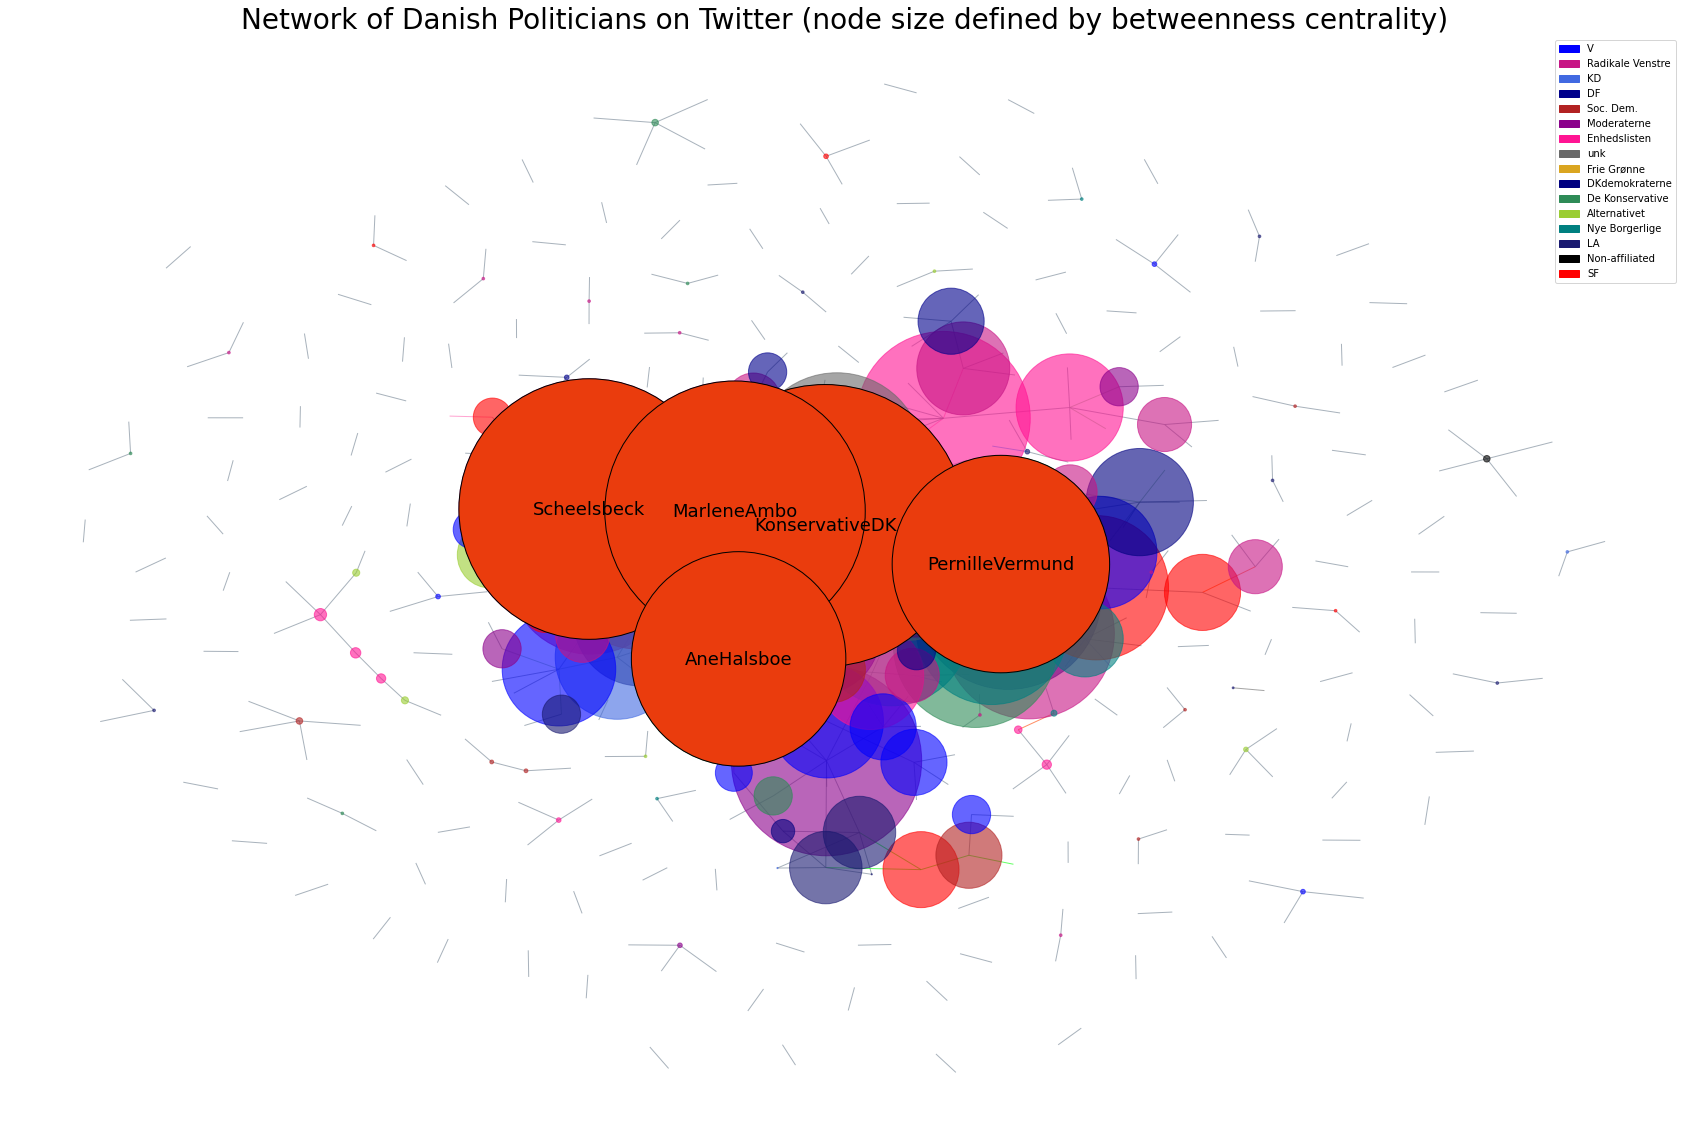

In [483]:
# 5 most central users
nodes_ = list(bet_c_sorted)[0:5]
fivemost_nodes = {}

for i in nodes_:
    fivemost_nodes[i] = bet_c_sorted[i]

plot_force_directed_graph(G_visualize, bet_c_sorted, fivemost_nodes,\
                          'Network of Danish Politicians on Twitter (node size defined by betweenness centrality)', 15)

**Eigenvector Centrality**

In [470]:
## Compute eigenvector centrality for in- and out-edges ##

# In-degree edges
in_eigen_c_ = nx.eigenvector_centrality(G)

# Out-degree edges
out_eigen_c_ = nx.eigenvector_centrality(G.reverse())

# sort both eigenvector centrality
in_eigen_c = sorted(in_eigen_c_.items(),key = lambda x:x[1],reverse = True)
out_eigen_c = sorted(out_eigen_c_.items(),key = lambda x:x[1],reverse = True)

# get the 5 most central characters according to eigenvector centrality
print('5 most central users (eigenvector centrality corresponding to in-edges):\n{}'.format(in_eigen_c[0:5]))
print(" ")
print('5 most central users (eigenvector centrality corresponding to out-edges):\n{}'.format(out_eigen_c[0:5]))

5 most central users (eigenvector centrality corresponding to in-edges):
[('RosaLundEl', 0.478092436720301), ('Kvinderaadet', 0.4780901285004536), ('JinoVDoabi', 0.4780901285004536), ('Halime9Oguz', 0.11952315726798882), ('jobywatermusic', 0.11952315726798882)]
 
5 most central users (eigenvector centrality corresponding to out-edges):
[('PLindhoutTravel', 0.5477203659306094), ('jobywatermusic', 0.4564336400892131), ('Scheelsbeck', 0.27388121286904105), ('Halime9Oguz', 0.2738601884064186), ('RosaLundEl', 0.2738601884064186)]


In [472]:
in_deg_A = []
in_deg_B = []
in_deg_C = []
in_deg_D = []
in_deg_F = []
in_deg_I = []
in_deg_K = []
in_deg_M = []
in_deg_O = []
in_deg_Q = []
in_deg_V = []
in_deg_Æ = []
in_deg_Ø = []
in_deg_Å = []
in_deg_UDEN = []

out_deg_A = []
out_deg_B = []
out_deg_C = []
out_deg_D = []
out_deg_F = []
out_deg_I = []
out_deg_K = []
out_deg_M = []
out_deg_O = []
out_deg_Q = []
out_deg_V = []
out_deg_Æ = []
out_deg_Ø = []
out_deg_Å = []
out_deg_UDEN = []

# Define colors for all parties
for node in tqdm(list(G.nodes())):
    if nx.get_node_attributes(G,'party')[node] == 'A': # Soc. Dem.
        in_deg_A.append(in_eigen_c_[node])
        out_deg_A.append(out_eigen_c_[node])

    elif nx.get_node_attributes(G,'party')[node] == 'B': # Radikale venstre
        in_deg_B.append(in_eigen_c_[node])
        out_deg_B.append(out_eigen_c_[node])

    elif nx.get_node_attributes(G,'party')[node] == 'C': # Konservative
        in_deg_C.append(in_eigen_c_[node])
        out_deg_C.append(out_eigen_c_[node])

    elif nx.get_node_attributes(G,'party')[node] == 'D': # Nye Borgerlige
        in_deg_D.append(in_eigen_c_[node])
        out_deg_D.append(out_eigen_c_[node])

    elif nx.get_node_attributes(G,'party')[node] == 'F': # SF
        in_deg_F.append(in_eigen_c_[node])
        out_deg_F.append(out_eigen_c_[node])

    elif nx.get_node_attributes(G,'party')[node] == 'I': # LA
        in_deg_I.append(in_eigen_c_[node])
        out_deg_I.append(out_eigen_c_[node])

    elif nx.get_node_attributes(G,'party')[node] == 'K': # KD
        in_deg_K.append(in_eigen_c_[node])
        out_deg_K.append(out_eigen_c_[node])

    elif nx.get_node_attributes(G,'party')[node] == 'M': # Moderaterne
        in_deg_M.append(in_eigen_c_[node])
        out_deg_M.append(out_eigen_c_[node])

    elif nx.get_node_attributes(G,'party')[node] == 'O': # DF
        in_deg_O.append(in_eigen_c_[node])
        out_deg_O.append(out_eigen_c_[node])

    elif nx.get_node_attributes(G,'party')[node] == 'Q': # Frie grønne
        in_deg_Q.append(in_eigen_c_[node])
        out_deg_Q.append(out_eigen_c_[node])

    elif nx.get_node_attributes(G,'party')[node] == 'V': # Venstre
        in_deg_V.append(in_eigen_c_[node])
        out_deg_V.append(out_eigen_c_[node])

    elif nx.get_node_attributes(G,'party')[node] == 'Æ': # DK demokraterne
        in_deg_Æ.append(in_eigen_c_[node])
        out_deg_Æ.append(out_eigen_c_[node])

    elif nx.get_node_attributes(G,'party')[node] == 'Ø': # Enhedslisten
        in_deg_Ø.append(in_eigen_c_[node])
        out_deg_Ø.append(out_eigen_c_[node])

    elif nx.get_node_attributes(G,'party')[node] == 'Å': # Alternativet
        in_deg_Å.append(in_eigen_c_[node])
        out_deg_Å.append(out_eigen_c_[node])

    elif nx.get_node_attributes(G,'party')[node] == 'UDEN':
        in_deg_UDEN.append(in_eigen_c_[node])
        out_deg_UDEN.append(out_eigen_c_[node])

  0%|          | 0/646 [00:00<?, ?it/s]

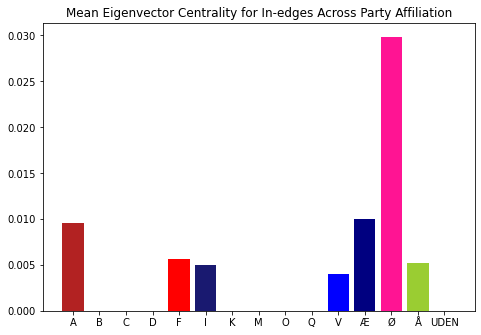

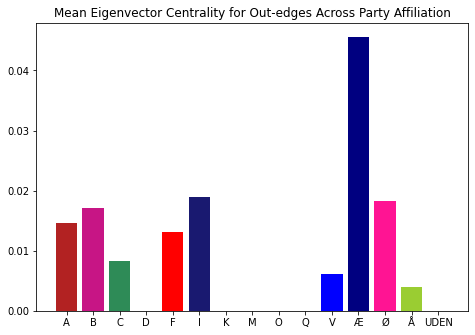

In [473]:
party_aff_plot(unique_parties_lst, [np.mean(in_deg_A), np.mean(in_deg_B), np.mean(in_deg_C), np.mean(in_deg_D), np.mean(in_deg_F), np.mean(in_deg_I), np.mean(in_deg_K), np.mean(in_deg_M), np.mean(in_deg_O), np.mean(in_deg_Q), np.mean(in_deg_V), np.mean(in_deg_Æ), np.mean(in_deg_Ø), np.mean(in_deg_Å), np.mean(in_deg_UDEN)], "Mean Eigenvector Centrality for In-edges Across Party Affiliation",color_dict_)
party_aff_plot(unique_parties_lst, [np.mean(out_deg_A), np.mean(out_deg_B), np.mean(out_deg_C), np.mean(out_deg_D), np.mean(out_deg_F), np.mean(out_deg_I), np.mean(out_deg_K), np.mean(out_deg_M), np.mean(out_deg_O), np.mean(out_deg_Q), np.mean(out_deg_V), np.mean(out_deg_Æ), np.mean(out_deg_Ø), np.mean(out_deg_Å), np.mean(out_deg_UDEN)], "Mean Eigenvector Centrality for Out-edges Across Party Affiliation",color_dict_)

  0%|          | 0/646 [00:00<?, ?it/s]

  0%|          | 0/490 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:17<00:00, 113.79it/s]


BarnesHut Approximation  took  2.66  seconds
Repulsion forces  took  14.16  seconds
Gravitational forces  took  0.07  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.40  seconds


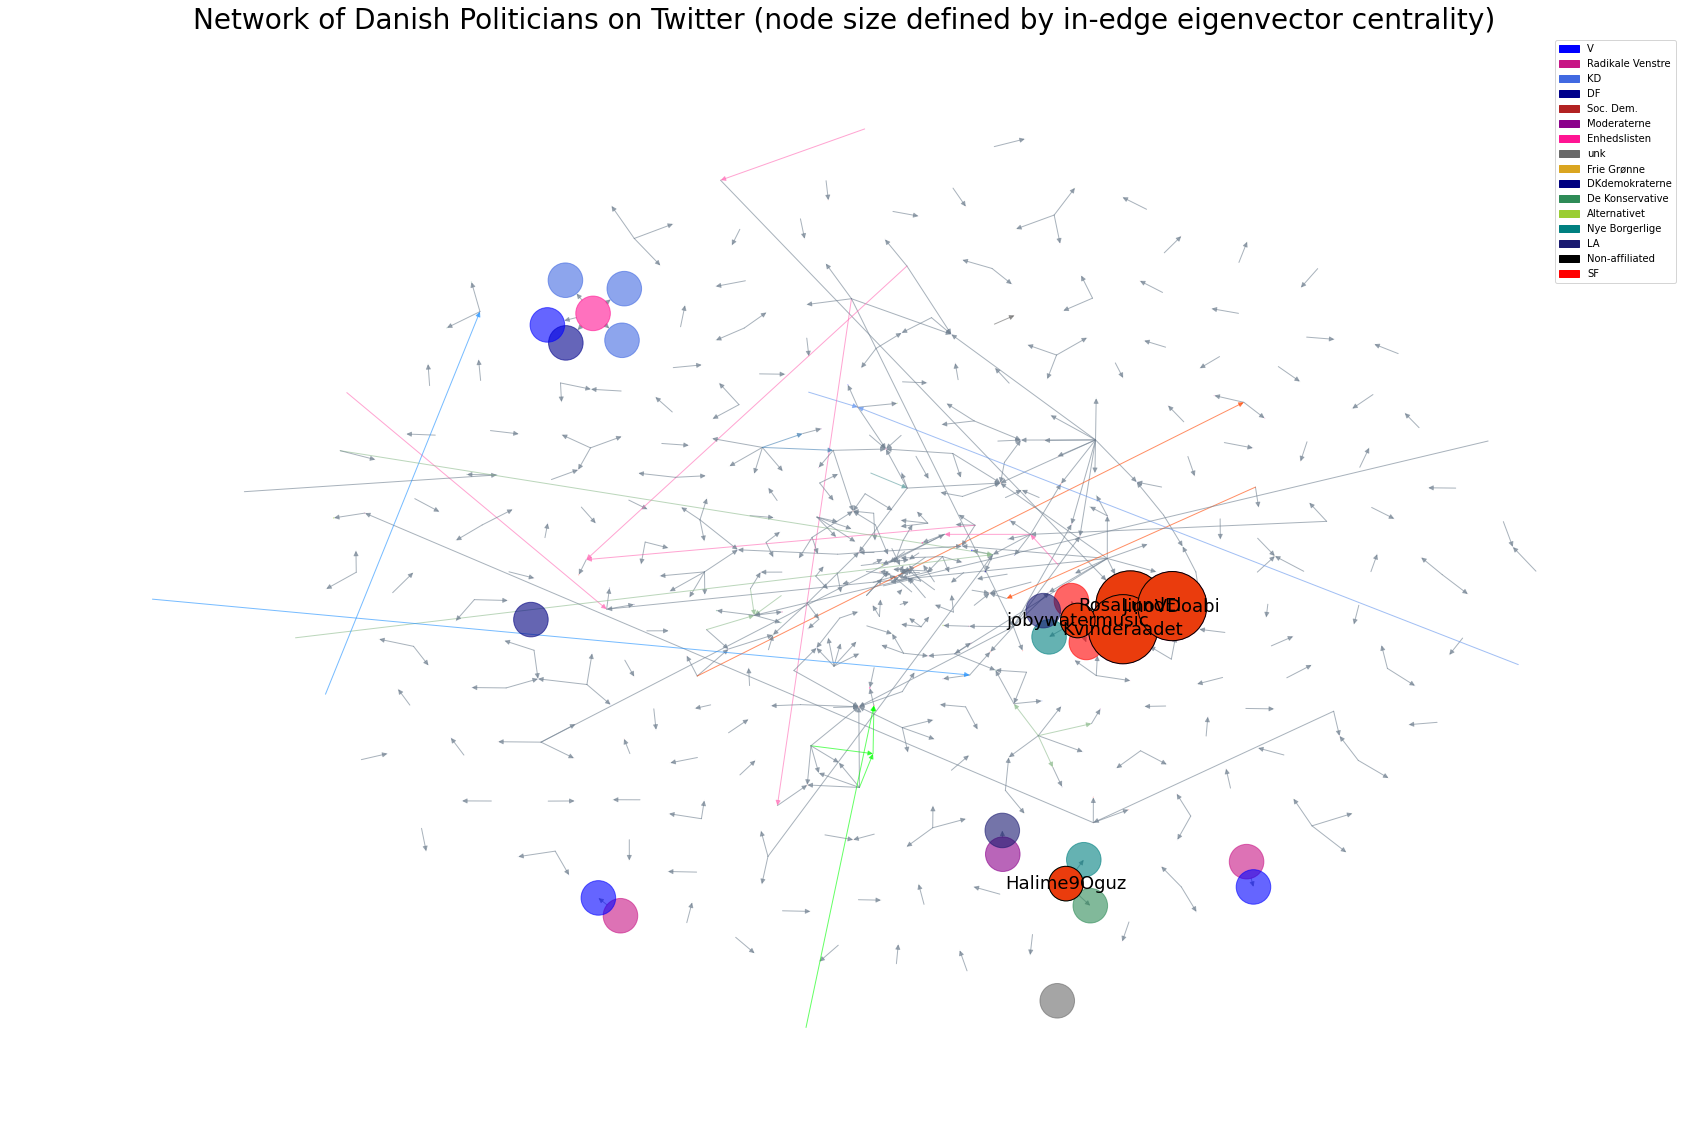

In [484]:
# Scale for better plotting
in_eigen_c_plot = dict(in_eigen_c)
in_eigen_c_plot.update((x, y*10000) for x, y in in_eigen_c_plot.items())

# Take top five
nodes_ = list(in_eigen_c_plot)[0:5]

fivemost_nodes = {}
for i in nodes_:
    fivemost_nodes[i] = in_eigen_c_plot[i]
    
plot_force_directed_graph(G, in_eigen_c_plot,fivemost_nodes,\
                          'Network of Danish Politicians on Twitter (node size defined by in-edge eigenvector centrality)', 1)

  0%|          | 0/646 [00:00<?, ?it/s]

  0%|          | 0/490 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:17<00:00, 112.11it/s]


BarnesHut Approximation  took  3.07  seconds
Repulsion forces  took  13.99  seconds
Gravitational forces  took  0.08  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.37  seconds


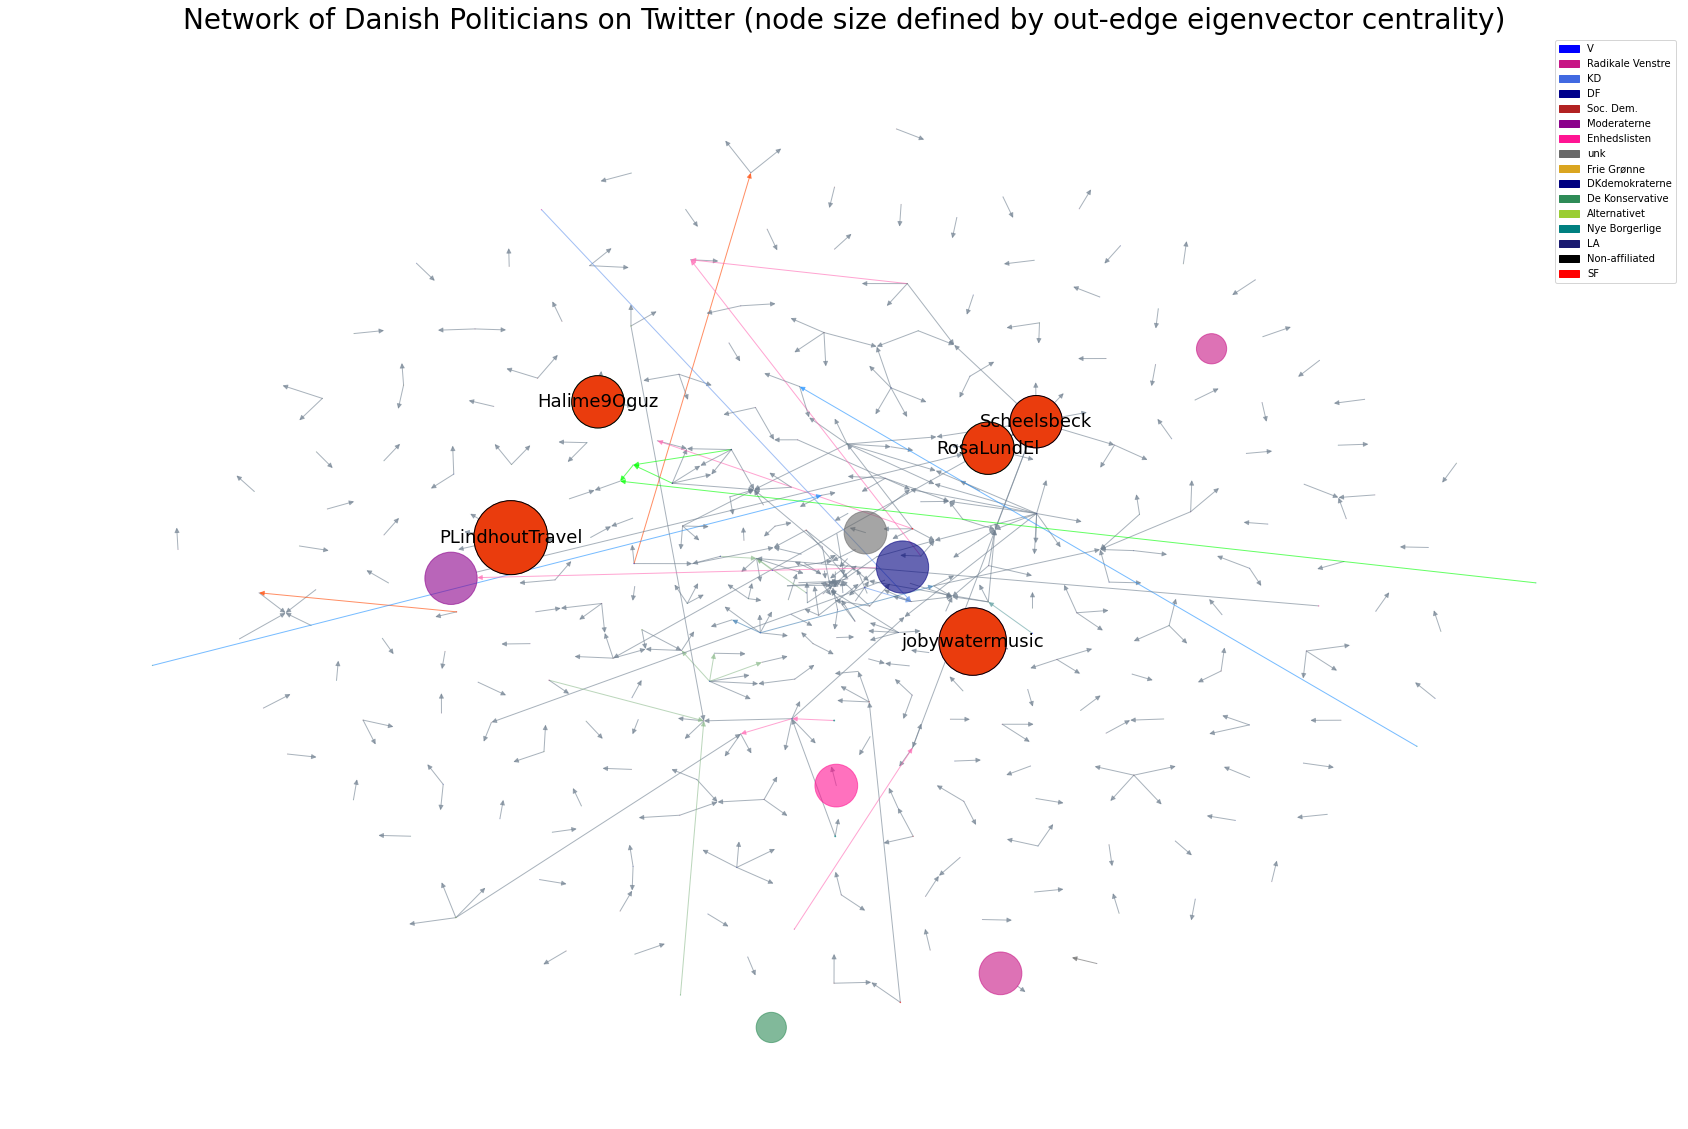

In [485]:
# Scaling for better plot
out_eigen_c_plot = dict(out_eigen_c)
out_eigen_c_plot.update((x, y*10000) for x, y in out_eigen_c_plot.items())

# Grab top five nodes with highest out-edge eigenvector centrality
nodes_ = list(out_eigen_c_plot)[0:5]

fivemost_nodes = {}
for i in nodes_:
    fivemost_nodes[i] = out_eigen_c_plot[i]

plot_force_directed_graph(G, out_eigen_c_plot,fivemost_nodes,\
                          'Network of Danish Politicians on Twitter (node size defined by out-edge eigenvector centrality)', 1)

**How are nodes linked?**

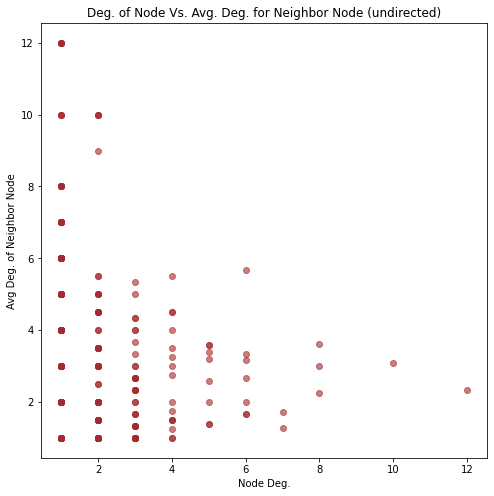

In [158]:
# undirected marvel network
avg_neigh_degrees = nx.average_neighbor_degree(G_visualize)

# plot
plt.figure(figsize=(8,8))
plt.scatter(dict(G_visualize.degree()).values(),avg_neigh_degrees.values(),c= 'brown',alpha=0.6)
plt.title('Deg. of Node Vs. Avg. Deg. for Neighbor Node (undirected)')
plt.xlabel('Node Deg.')
plt.ylabel('Avg Deg. of Neighbor Node')
plt.show()

## Results with 'unk' Users Removed

In [299]:
unks = []
for node in tqdm(list(G.nodes())):
    if nx.get_node_attributes(G,'party')[node] == 'unk':
        unks.append(node)

G.remove_nodes_from(unks)


  0%|          | 0/646 [00:00<?, ?it/s]

In [300]:
print("Number of edges:")
len(G.edges)

Number of edges:


57

In [301]:
print("Number of Nodes:")
len(G.nodes)

Number of Nodes:


283

**Check in/out-degree:**

In [302]:
# In-degrees
tuples_in_deg = G.in_degree(G.nodes())
in_deg = [x[1] for x in tuples_in_deg] 

# Out-degrees
tuples_out_deg = G.out_degree(G.nodes())
out_deg = [x[1] for x in tuples_out_deg] 

print('In degree\tmax: {}\tmin: {}\tmedian: {}'.format(max(in_deg),min(in_deg), np.median(in_deg)))
print('Out degree\tmax: {}\tmin: {}\tmedian: {}'.format(max(out_deg),min(out_deg),np.median(out_deg)))
print('Nodes with in-degree larger than 100: {}'.format(len([i for i in in_deg if i >5])))


In degree	max: 4	min: 0	median: 0.0
Out degree	max: 4	min: 0	median: 0.0
Nodes with in-degree larger than 100: 0


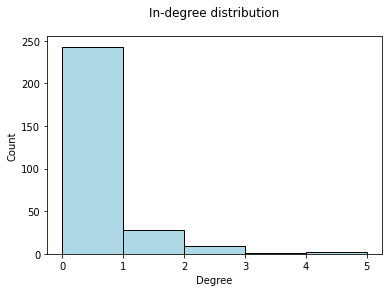

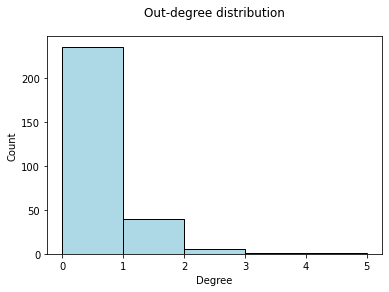

In [303]:
## Plot degree distributions
plt.title("In-degree distribution",pad = 20.0)
plt.hist(in_deg, bins = np.arange(np.min(in_deg), np.max(in_deg)+2), color = 'lightblue', edgecolor = 'black')
plt.ylabel("Count")
plt.xlabel("Degree")
plt.show()

plt.title("Out-degree distribution",pad = 20.0)
plt.hist(out_deg, bins = np.arange(np.min(out_deg), np.max(out_deg)+2), color = 'lightblue', edgecolor = 'black')
plt.ylabel("Count")
plt.xlabel("Degree")
plt.show()

In [304]:
## Most connected users
in_deg_dict = dict(G.in_degree(G.nodes))
print("Top most in-degree connected users: ,", sorted(in_deg_dict, key=in_deg_dict.get, reverse=True)[:20])

out_deg_dict = dict(G.out_degree(G.nodes))
print("Top most out-degree connected users: ,", sorted(out_deg_dict, key=out_deg_dict.get, reverse=True)[:10])

Top most in-degree connected users: , ['metteabildgaard', 'SorenPape', 'RosaLundEl', 'rasmushelveg', 'sofiecn', 'PHummelgaard', 'Ammitzboell_K', 'TScavenius', 'martinlidegaard', 'JacobNetteberg', 'StigGrenov', 'TorstenGejl', 'khoenge', 'JThulesen', 'RasmusJarlov', 'MrMesserschmidt', 'mettereissmann', 'carolinamaier', 'ThomasRohden', 'Halime9Oguz']
Top most out-degree connected users: , ['Scheelsbeck', 'hannebjornk', 'brittbager', 'ViviNoer', 'AmdiBurgess', 'martinlidegaard', 'ThDanielsen', 'UllaKokfelt', 'JohnnieVG', 'lars_aslan']


In [305]:
# Convert to undirected graph for visualization purposes (so we do not end up with a lot of arrows)
G_visualize = G.to_undirected()

color_map_nodes, color_map_edge, degree_dict = color_maps(G_visualize, pol_spec = False)

  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:06<00:00, 330.37it/s]


BarnesHut Approximation  took  0.78  seconds
Repulsion forces  took  4.91  seconds
Gravitational forces  took  0.03  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.18  seconds


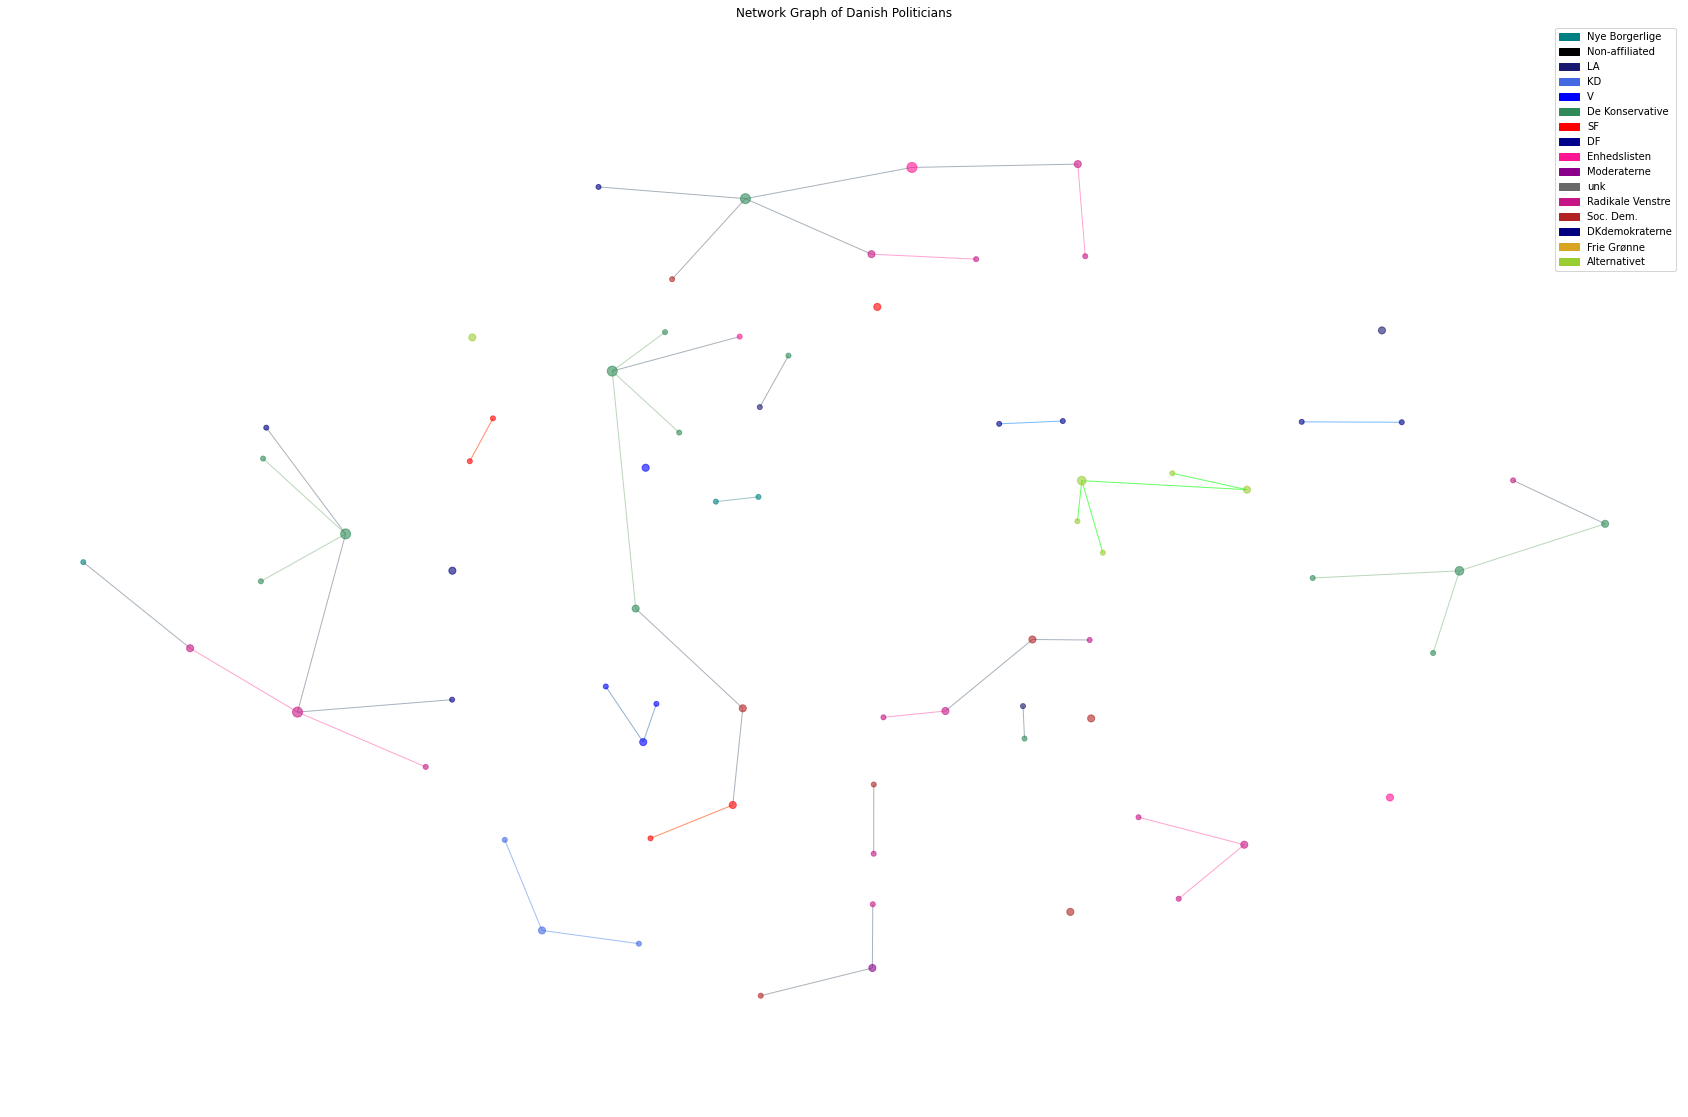

In [306]:
## Plotting network ## 
plt.figure(figsize = (30,20))

forceatlas2 = ForceAtlas2(
                        ## Behavior alternatives ##
                        outboundAttractionDistribution=False, # Dissuation
                        linLogMode=False,
                        adjustSizes=False, 
                        edgeWeightInfluence=1.0,

                        ## Performance ##
                        jitterTolerance=1.0,  # Tolerance level
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,

                        ## Tuning ##
                        scalingRatio=0.1,
                        strongGravityMode=False,
                        gravity=10.0,

                        ## Logging ##
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(G_visualize, pos=None, iterations=2000)

nx.draw_networkx(G_visualize, positions,nodelist=degree_dict.keys(), node_size=[v * 25 for v in degree_dict.values()], node_color = color_map_nodes,alpha = 0.6, edge_color = color_map_edge,with_labels=False, labels = color_map_legend.items())

plt.axis('off')
plt.title('Network Graph of Danish Politicians')
plt.legend(handles = handles_dict)
plt.show()

In [307]:
# Extract largest component
gcc = max(nx.weakly_connected_components(G), key=len)
gcc_subgraph = G.subgraph(gcc)
gcc_visualize = gcc_subgraph.to_undirected()

color_map_nodes, color_map_edge, degree_dict = color_maps(gcc_visualize, pol_spec = False)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:00<00:00, 39991.65it/s]

BarnesHut Approximation  took  0.01  seconds
Repulsion forces  took  0.01  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.01  seconds


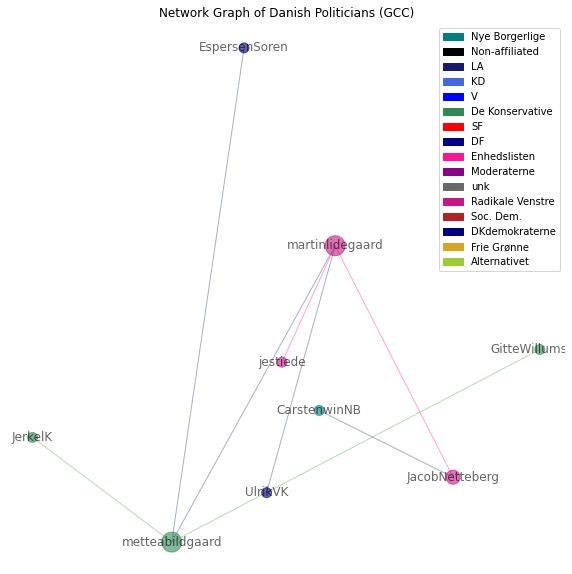

In [308]:
## Plotting network (GCC) ##
plt.figure(figsize = (10,10))

forceatlas2 = ForceAtlas2(
                        ## Behavior alternatives ##
                        outboundAttractionDistribution=False, # Dissuation
                        linLogMode=False,
                        adjustSizes=False, 
                        edgeWeightInfluence=1.0,

                        ## Performance ##
                        jitterTolerance=1.0,  # Tolerance level
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,

                        ## Tuning ##
                        scalingRatio=0.1,
                        strongGravityMode=False,
                        gravity=10.0,

                        ## Logging ##
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(gcc_visualize, pos=None, iterations=2000)

nx.draw_networkx(gcc_visualize, positions,nodelist=degree_dict.keys(), node_size=[v * 100 for v in degree_dict.values()], node_color = color_map_nodes,alpha = 0.6, edge_color = color_map_edge,with_labels=True)

plt.axis('off')
plt.title('Network Graph of Danish Politicians (GCC)')
plt.legend(handles = handles_dict)
plt.show()

In [309]:
print("Number of nodes in GCC:")
print(len(gcc_visualize.nodes))

Number of nodes in GCC:
9


In [310]:
print("Number of edges in GCC:")
print(len(gcc_visualize.edges))

Number of edges in GCC:
8


  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:06<00:00, 316.12it/s]


BarnesHut Approximation  took  0.93  seconds
Repulsion forces  took  5.10  seconds
Gravitational forces  took  0.03  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.16  seconds


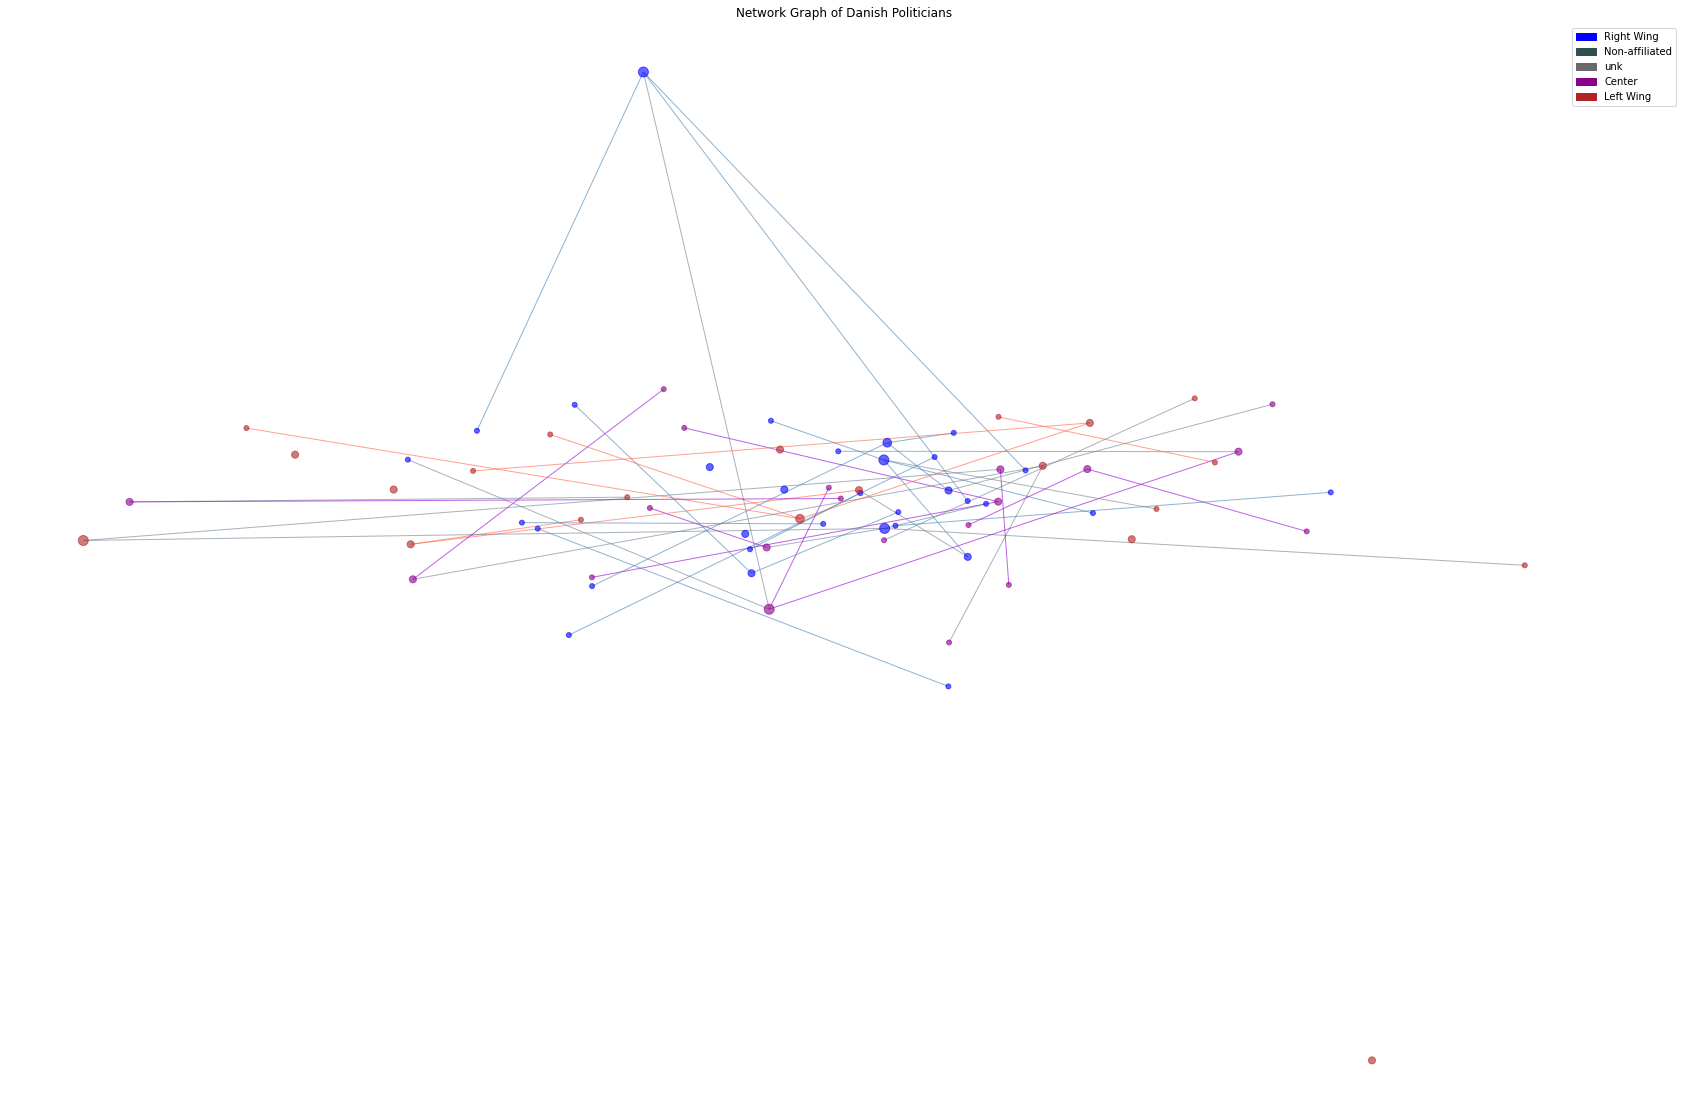

In [311]:
color_map_nodes, color_map_edge, degree_dict = color_maps(G_visualize, pol_spec = True)

## Plotting network ## 
plt.figure(figsize = (30,20))

forceatlas2 = ForceAtlas2(
                        ## Behavior alternatives ##
                        outboundAttractionDistribution=False, # Dissuation
                        linLogMode=False,
                        adjustSizes=False, 
                        edgeWeightInfluence=1.0,

                        ## Performance ##
                        jitterTolerance=1.0,  # Tolerance level
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,

                        ## Tuning ##
                        scalingRatio=0.1,
                        strongGravityMode=False,
                        gravity=80,

                        ## Logging ##
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(G_visualize, pos=None, iterations=2000)

nx.draw_networkx(G_visualize, positions,nodelist=degree_dict.keys(), node_size=[v * 25 for v in degree_dict.values()], node_color = color_map_nodes,alpha = 0.6, edge_color = color_map_edge,with_labels=False, labels = color_map_legend_pol_spectrum.items())

plt.axis('off')
plt.title('Network Graph of Danish Politicians')
plt.legend(handles = handles_dict_pol_spec)
plt.show()

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:00<00:00, 40000.80it/s]

BarnesHut Approximation  took  0.01  seconds
Repulsion forces  took  0.02  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.01  seconds


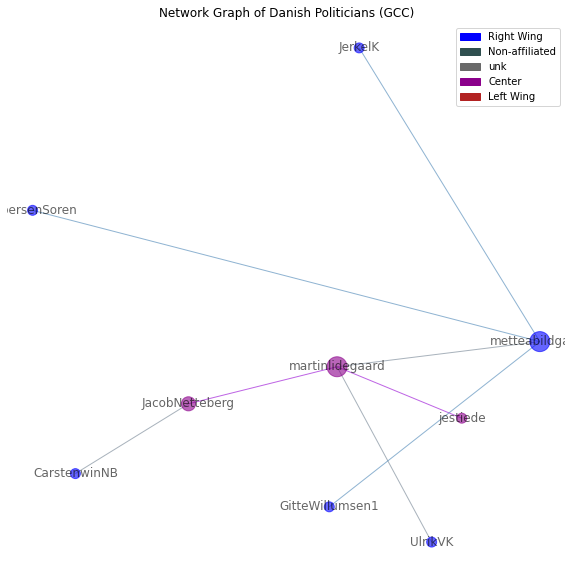

In [312]:
color_map_nodes, color_map_edge, degree_dict = color_maps(gcc_visualize, pol_spec = True)

## Plotting network (GCC) ##
plt.figure(figsize = (10,10))

forceatlas2 = ForceAtlas2(
                        ## Behavior alternatives ##
                        outboundAttractionDistribution=False, # Dissuation
                        linLogMode=False,
                        adjustSizes=False, 
                        edgeWeightInfluence=1.0,

                        ## Performance ##
                        jitterTolerance=1.0,  # Tolerance level
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,

                        ## Tuning ##
                        scalingRatio=0.1,
                        strongGravityMode=False,
                        gravity=10.0,

                        ## Logging ##
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(gcc_visualize, pos=None, iterations=2000)

nx.draw_networkx(gcc_visualize, positions,nodelist=degree_dict.keys(), node_size=[v * 100 for v in degree_dict.values()], node_color = color_map_nodes,alpha = 0.6, edge_color = color_map_edge,with_labels=True)

plt.axis('off')
plt.title('Network Graph of Danish Politicians (GCC)')
plt.legend(handles = handles_dict_pol_spec)
plt.show()

**Finding communities:**

In [313]:
part = community_louvain.best_partition(G_visualize)

In [314]:
comms = np.unique(list(part.values()))

In [315]:
## Compute modularity for paritition ##

# Obtain representation of communities for nx_comm.modularity func
comms_dict = {}
for k, v in part.items():
    str_v_ = str(v)
    if str_v_ not in comms_dict.keys():
        comms_dict[str_v_] = [k]
    else:
        comms_dict[str_v_].append(k)

comms_list = [v for k,v in comms_dict.items()]

M = nx_comm.modularity(G_visualize, comms_list)

print('Partition modularity : {}'.format(M))

Partition modularity : 0.9233610341643577


In [316]:
print("Number of found communities:")
print(max(comms))

comm_3_n = [i for i in comms_list if len(i) >=3]

print('Number of communities with more than 3 nodes: {}'.format(len(comm_3_n)))

Number of found communities:
234
Number of communities with more than 3 nodes: 10


In [317]:
# Reorganizing into dict
d_input = dict(part.items())
res = {}

for i, v in d_input.items():
    res[v] = [i] if v not in res.keys() else res[v] + [i]

In [318]:
c = 0
top_comms = sorted(res.items(), key=lambda v: len(v[1]), reverse=True)[:16]
comm_tweets = []

for i,t in enumerate(top_comms):
    comm_tweets.append(np.concatenate(tweets_w_mentions.loc[tweets_w_mentions['user_handle'].isin(t[1])]['tokenized'].values))
    
    print(f"Community {i+1}. Size: {len(t[1])}")
    c += len(t[1])
    
print(f"\nCirca {int(np.round(c/len(G_visualize.nodes), 2)*100)}% of network nodes represented in these partitions.")

Community 1. Size: 9
Community 2. Size: 8
Community 3. Size: 8
Community 4. Size: 5
Community 5. Size: 5
Community 6. Size: 4
Community 7. Size: 3
Community 8. Size: 3
Community 9. Size: 3
Community 10. Size: 3
Community 11. Size: 2
Community 12. Size: 2
Community 13. Size: 2
Community 14. Size: 2
Community 15. Size: 2
Community 16. Size: 2

Circa 22% of network nodes represented in these partitions.


**Inspect Party Affiliation of Users in Top Communities**

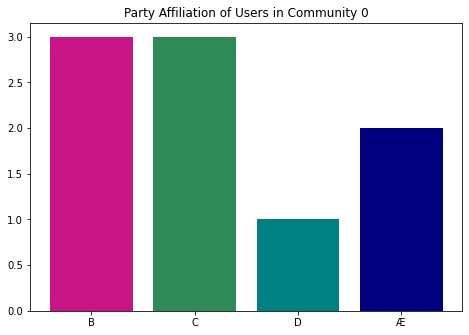

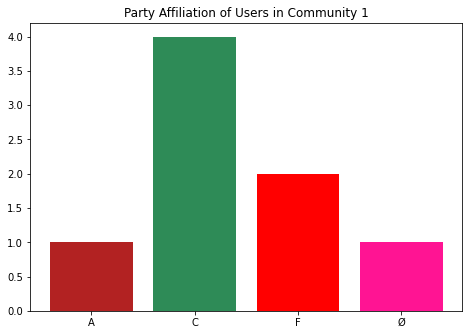

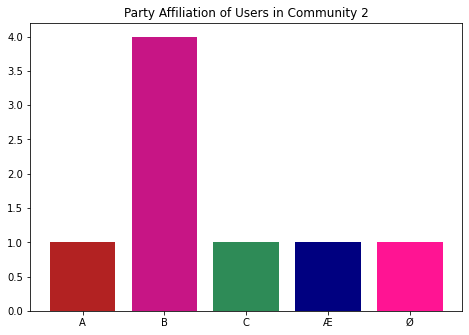

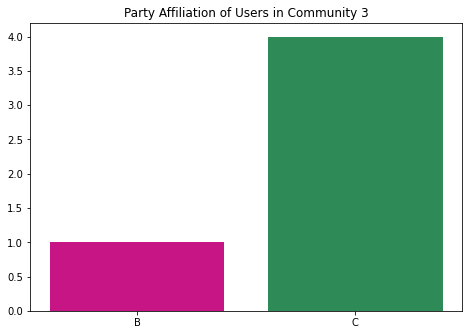

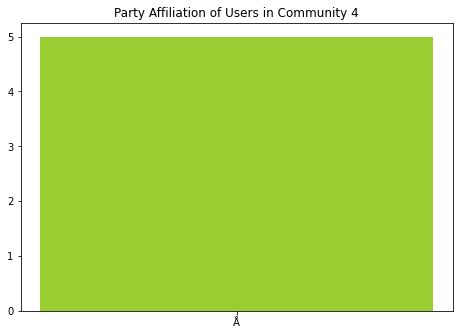

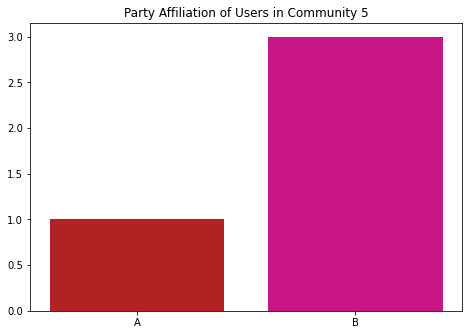

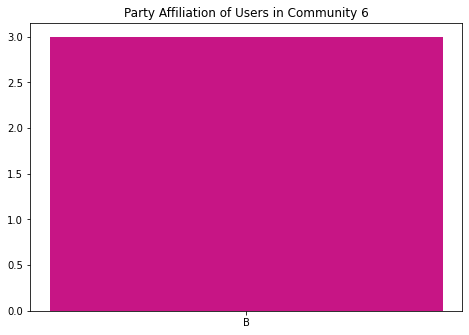

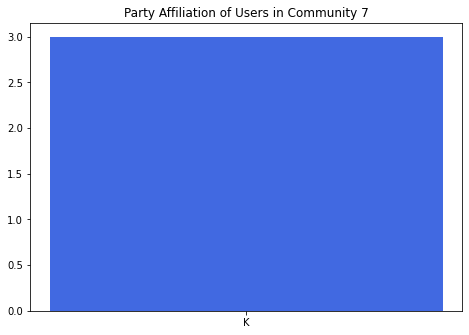

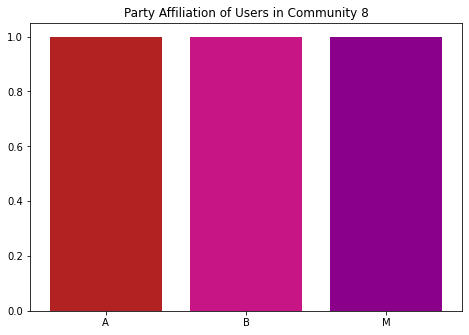

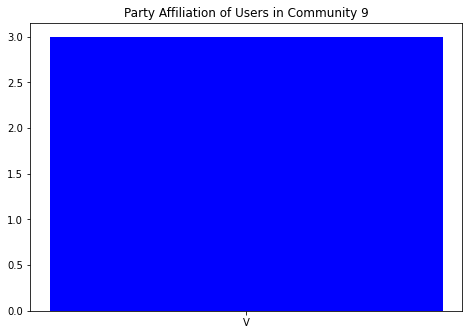

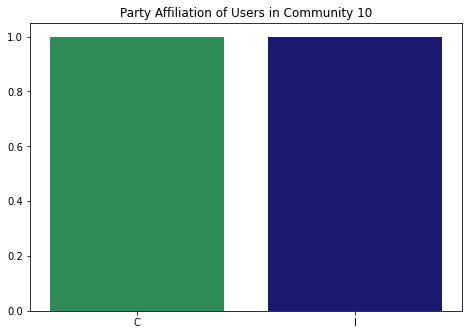

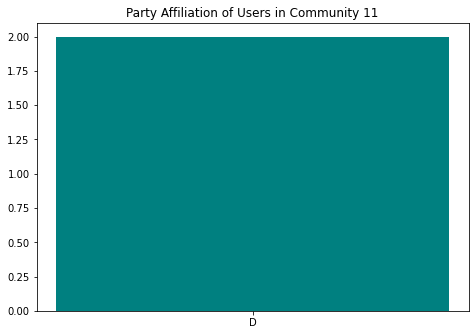

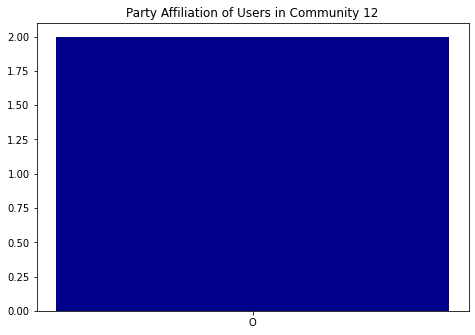

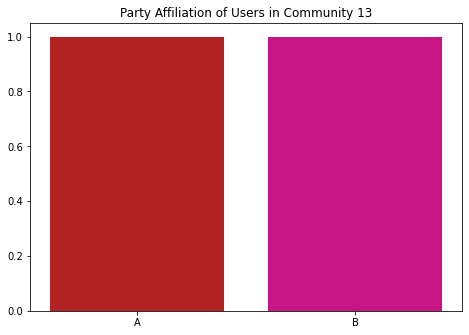

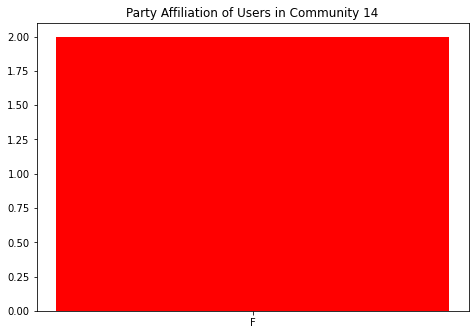

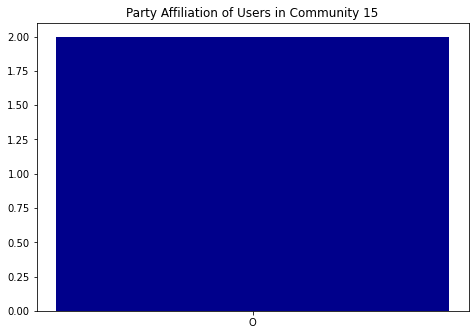

In [319]:
for i, _ in enumerate(top_comms):
    unique_list, count_list = unique_and_count(get_parties(top_comms[i][1]))
    party_aff_plot(unique_list, count_list, f"Party Affiliation of Users in Community {i}", color_dict)

In [320]:
for i, _ in enumerate(top_comms):
    print(f"Parties in Community {i+1}:")
    unique_list, count_list = unique_and_count(get_parties(top_comms[i][1]))
    print(dict(zip(unique_list, count_list)))
    print(" ")

Parties in Community 1:
{'B': 3, 'C': 3, 'D': 1, 'Æ': 2}
 
Parties in Community 2:
{'A': 1, 'C': 4, 'F': 2, 'Ø': 1}
 
Parties in Community 3:
{'A': 1, 'B': 4, 'C': 1, 'Æ': 1, 'Ø': 1}
 
Parties in Community 4:
{'B': 1, 'C': 4}
 
Parties in Community 5:
{'Å': 5}
 
Parties in Community 6:
{'A': 1, 'B': 3}
 
Parties in Community 7:
{'B': 3}
 
Parties in Community 8:
{'K': 3}
 
Parties in Community 9:
{'A': 1, 'B': 1, 'M': 1}
 
Parties in Community 10:
{'V': 3}
 
Parties in Community 11:
{'C': 1, 'I': 1}
 
Parties in Community 12:
{'D': 2}
 
Parties in Community 13:
{'O': 2}
 
Parties in Community 14:
{'A': 1, 'B': 1}
 
Parties in Community 15:
{'F': 2}
 
Parties in Community 16:
{'O': 2}
 


**Visualizing TF-IDF Word Clouds for Top 16 Communities**

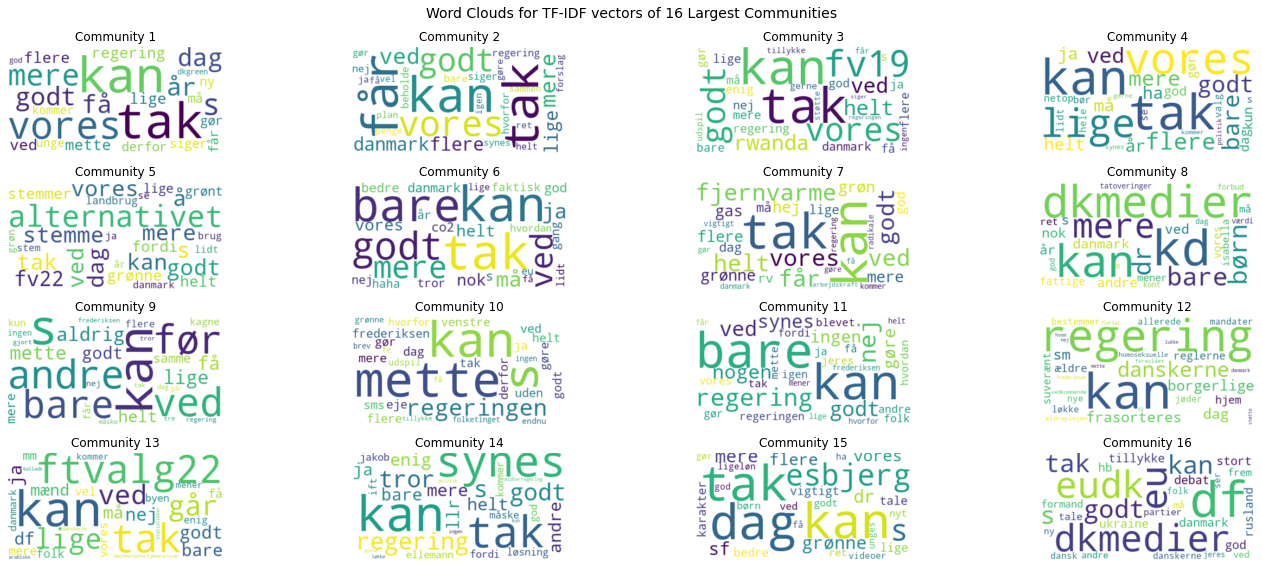

In [321]:
# Calculate TF
tf_tweets = pd.Series(comm_tweets).apply(nltk.FreqDist)

# Compute document frequency
d_freq = nltk.FreqDist(np.concatenate(pd.Series(comm_tweets).apply(lambda x: list(set(x))).values))

# Compute IDF
N = 16
idf_vals = np.log10(((1+N)/(1+np.array(list(d_freq.values()))))) + 1

idf = dict(zip(d_freq.keys(), idf_vals))
series_TF_IDF = pd.Series(tf_tweets).apply(lambda x: tf_idf(x, idf))

fig, ax = plt.subplots(4, 4, figsize= (20, 8))

c = 0
for i in range(4):
    for j in range(4):
        w_list = sorted(series_TF_IDF[c], key=series_TF_IDF[c].get, reverse=True)[:30]
        wordcloud = WordCloud(max_font_size=90, max_words=30, background_color="white").generate(" ".join(w_list))
        ax[i][j].imshow(wordcloud, interpolation="bilinear")
        ax[i][j].set_axis_off()
        ax[i][j].set_title(f"Community {c+1}")
        c += 1
        
fig.suptitle("Word Clouds for TF-IDF vectors of 16 Largest Communities", fontsize = 14)
fig.tight_layout()
plt.show()